In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from geoband.API import *
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

import folium
import json
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap

import pyproj
from fiona.crs import from_epsg

import lightgbm as lgb
import random
from sklearn.metrics import mean_squared_log_error

from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_boston
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
from sklearn.model_selection import GridSearchCV

from folium import plugins
from spglm.family import Gaussian, Poisson, Binomial

from shapely.geometry import Point, shape, mapping
from shapely.ops import unary_union
from sklearn import neighbors
from sklearn.preprocessing import minmax_scale
import math


from geoband.API import *

데이터를 어린이 보호구역 외의 데이터와 어린이 보호구역 내의 데이터로 구분을 지었고, 각 구역에 대해 각각 모델링을 진행하였다.

# Dataset for no child

In [26]:
dataset = pd.read_csv('dataset2.txt', delimiter = '\t')
dataset_nochild = dataset[dataset['schoolzone_num']==0]
dataset_nochild = dataset_nochild.drop(['Unnamed: 0', 'geometry'], axis=1)
GetCompasData('SBJ_2012_001', '2', '2.오산시_어린이교통사고_격자.geojson')
data2 = gpd.read_file('2.오산시_어린이교통사고_격자.geojson')
del data2['accident_cnt']
dataset_nochild = pd.merge(dataset_nochild, data2, on='gid')
dataset_nochild

,gid,accident_cnt,schoolzone_num,safetysign_num,bump_num,child_num,school_num,facility_num,signal_num,busstop_num,...,ill_park,car_num,node,park_YN,foot_traf_mean,traffic,bigcar_ratio,rushhour_freq,road_width,geometry
0,다사564096,1,0,1,0,0.0,0,0,0,0,...,0,0,1,0,42.714375,4779.710000,0.232100,4.6300,0.500,"MULTIPOLYGON (((127.00880 37.18416, 127.00879 ..."
1,다사569091,0,0,0,0,0.0,0,0,0,0,...,0,0,1,0,17.366065,2982.066667,0.338792,35.0050,0.500,"MULTIPOLYGON (((127.01446 37.17968, 127.01445 ..."
2,다사569092,0,0,1,0,0.0,0,0,0,0,...,0,1,0,1,27.409931,4835.990000,0.232096,5.2850,0.500,"MULTIPOLYGON (((127.01445 37.18058, 127.01445 ..."
3,다사569093,0,0,0,0,0.0,0,0,0,0,...,0,0,0,1,7.110000,4835.990000,0.232096,5.2850,0.500,"MULTIPOLYGON (((127.01445 37.18148, 127.01444 ..."
4,다사570088,0,0,0,0,0.0,0,0,0,0,...,0,3,0,0,11.820111,1607.680000,0.372530,99.7800,0.250,"MULTIPOLYGON (((127.01560 37.17698, 127.01559 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,다사640065,0,0,0,0,0.0,0,0,0,0,...,5,0,0,0,2.442500,1936.405000,0.117912,29.0625,0.625,"MULTIPOLYGON (((127.09457 37.15654, 127.09456 ..."
1376,다사640066,0,0,0,0,0.0,0,0,0,0,...,77,0,0,0,171.749722,2293.930000,0.057351,19.6000,0.500,"MULTIPOLYGON (((127.09456 37.15744, 127.09456 ..."
1377,다사640067,0,0,0,0,0.0,0,0,0,0,...,4,0,0,0,0.000000,2293.930000,0.057351,19.6000,0.500,"MULTIPOLYGON (((127.09456 37.15834, 127.09455 ..."
1378,다사641063,0,0,0,0,0.0,0,0,0,0,...,9,0,1,0,9.059167,1578.880000,0.178473,38.5250,0.750,"MULTIPOLYGON (((127.09570 37.15474, 127.09570 ..."


In [27]:
dataset_nochild = gpd.GeoDataFrame(dataset_nochild, geometry = dataset_nochild.geometry)
center = dataset_nochild.geometry.centroid
center = pd.DataFrame(data = center, columns = ['center'])
dataset_nochild = pd.concat((dataset_nochild, center), axis=1)
dataset_nochild.set_crs(epsg=4326, inplace=True)
dataset_nochild['lat'] = dataset_nochild['center'].apply(lambda coord: coord.y)
dataset_nochild['lon'] = dataset_nochild['center'].apply(lambda coord: coord.x)
del dataset_nochild['center']
del dataset_nochild['schoolzone_num']
dataset_nochild

,gid,accident_cnt,safetysign_num,bump_num,child_num,school_num,facility_num,signal_num,busstop_num,crosswalk_num,...,node,park_YN,foot_traf_mean,traffic,bigcar_ratio,rushhour_freq,road_width,geometry,lat,lon
0,다사564096,1,1,0,0.0,0,0,0,0,0,...,1,0,42.714375,4779.710000,0.232100,4.6300,0.500,"MULTIPOLYGON (((127.00880 37.18416, 127.00879 ...",37.184612,127.009355
1,다사569091,0,0,0,0.0,0,0,0,0,0,...,1,0,17.366065,2982.066667,0.338792,35.0050,0.500,"MULTIPOLYGON (((127.01446 37.17968, 127.01445 ...",37.180128,127.015017
2,다사569092,0,1,0,0.0,0,0,0,0,0,...,0,1,27.409931,4835.990000,0.232096,5.2850,0.500,"MULTIPOLYGON (((127.01445 37.18058, 127.01445 ...",37.181030,127.015011
3,다사569093,0,0,0,0.0,0,0,0,0,0,...,0,1,7.110000,4835.990000,0.232096,5.2850,0.500,"MULTIPOLYGON (((127.01445 37.18148, 127.01444 ...",37.181931,127.015006
4,다사570088,0,0,0,0.0,0,0,0,0,0,...,0,0,11.820111,1607.680000,0.372530,99.7800,0.250,"MULTIPOLYGON (((127.01560 37.17698, 127.01559 ...",37.177429,127.016161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,다사640065,0,0,0,0.0,0,0,0,0,0,...,0,0,2.442500,1936.405000,0.117912,29.0625,0.625,"MULTIPOLYGON (((127.09457 37.15654, 127.09456 ...",37.156993,127.095126
1376,다사640066,0,0,0,0.0,0,0,0,0,0,...,0,0,171.749722,2293.930000,0.057351,19.6000,0.500,"MULTIPOLYGON (((127.09456 37.15744, 127.09456 ...",37.157894,127.095121
1377,다사640067,0,0,0,0.0,0,0,0,0,0,...,0,0,0.000000,2293.930000,0.057351,19.6000,0.500,"MULTIPOLYGON (((127.09456 37.15834, 127.09455 ...",37.158795,127.095116
1378,다사641063,0,0,0,0.0,0,0,0,0,0,...,1,0,9.059167,1578.880000,0.178473,38.5250,0.750,"MULTIPOLYGON (((127.09570 37.15474, 127.09570 ...",37.155194,127.096262


In [28]:
dataset_nochild.columns

Index(['gid', 'accident_cnt', 'safetysign_num', 'bump_num', 'child_num',
       'school_num', 'facility_num', 'signal_num', 'busstop_num',
       'crosswalk_num', 'sidewalk_num', 'ill_park', 'car_num', 'node',
       'park_YN', 'foot_traf_mean', 'traffic', 'bigcar_ratio', 'rushhour_freq',
       'road_width', 'geometry', 'lat', 'lon'],
      dtype='object')

In [29]:
corr = dataset_nochild.drop(['gid','lat','lon','geometry'],axis=1).corr()
corr.style.background_gradient(cmap='coolwarm')

,accident_cnt,safetysign_num,bump_num,child_num,school_num,facility_num,signal_num,busstop_num,crosswalk_num,sidewalk_num,ill_park,car_num,node,park_YN,foot_traf_mean,traffic,bigcar_ratio,rushhour_freq,road_width
accident_cnt,1.000000,0.319389,-0.008613,0.011532,0.008522,0.200735,0.405300,0.138921,0.302950,0.235485,0.184120,-0.004978,0.198135,0.017829,0.201771,0.056547,-0.031964,0.146533,0.060263
safetysign_num,0.319389,1.000000,-0.014114,-0.091362,-0.064891,0.114248,0.554018,0.067055,0.412146,0.291538,0.045826,-0.062861,0.219483,-0.025145,0.126611,0.095611,0.089338,-0.040705,0.131059
bump_num,-0.008613,-0.014114,1.000000,0.009848,0.027294,-0.018007,0.014092,-0.007352,-0.013315,-0.034795,0.040293,-0.002537,0.036496,0.012250,-0.005100,-0.068476,-0.069365,0.075842,-0.039217
child_num,0.011532,-0.091362,0.009848,1.000000,0.502699,0.063832,-0.033935,0.049140,-0.017621,-0.043842,-0.024148,0.295486,-0.083289,-0.050917,0.117588,-0.157603,-0.023696,0.117316,-0.032748
school_num,0.008522,-0.064891,0.027294,0.502699,1.000000,0.097560,-0.031772,0.010707,-0.032145,-0.055502,-0.015469,0.143479,-0.051748,-0.056858,0.072761,-0.116989,0.015638,0.093258,-0.026486
facility_num,0.200735,0.114248,-0.018007,0.063832,0.097560,1.000000,0.087921,0.065629,0.183440,0.088000,0.172939,0.053834,0.068029,-0.010442,0.158927,-0.048875,-0.014711,0.115965,0.018005
signal_num,0.405300,0.554018,0.014092,-0.033935,-0.031772,0.087921,1.000000,0.162012,0.556595,0.356957,0.107002,-0.026584,0.321095,0.028472,0.179951,-0.003425,0.029236,0.013029,0.132770
busstop_num,0.138921,0.067055,-0.007352,0.049140,0.010707,0.065629,0.162012,1.000000,0.104895,0.154107,0.057053,0.018641,0.049361,0.025632,0.186701,-0.001615,-0.046798,0.063498,0.049461
crosswalk_num,0.302950,0.412146,-0.013315,-0.017621,-0.032145,0.183440,0.556595,0.104895,1.000000,0.389500,0.201891,-0.001037,0.301992,0.073113,0.233243,-0.014225,0.029704,0.113837,0.110167
sidewalk_num,0.235485,0.291538,-0.034795,-0.043842,-0.055502,0.088000,0.356957,0.154107,0.389500,1.000000,0.118219,-0.006800,0.178294,-0.014479,0.170542,0.275169,0.012489,-0.001127,0.406793


In [30]:
dataset1 = dataset_nochild[dataset_nochild['accident_cnt']>0]
dataset1 = dataset1.reset_index(drop=True)
dataset1['for_split'] = 1 # 구분을 위해 만들어놓은 변수(의미 포함X)
dataset1

,gid,accident_cnt,safetysign_num,bump_num,child_num,school_num,facility_num,signal_num,busstop_num,crosswalk_num,...,park_YN,foot_traf_mean,traffic,bigcar_ratio,rushhour_freq,road_width,geometry,lat,lon,for_split
0,다사564096,1,1,0,0.0,0,0,0,0,0,...,0,42.714375,4779.710000,0.232100,4.630000,0.500000,"MULTIPOLYGON (((127.00880 37.18416, 127.00879 ...",37.184612,127.009355,1
1,다사583093,1,0,0,0.0,0,0,0,0,0,...,0,3.889444,2149.670000,0.332863,42.100000,0.500000,"MULTIPOLYGON (((127.03022 37.18154, 127.03021 ...",37.181995,127.030777,1
2,다사584072,1,3,0,0.0,0,0,8,0,7,...,0,32.844062,3110.487857,0.172335,26.552857,0.785714,"MULTIPOLYGON (((127.03146 37.16262, 127.03145 ...",37.163070,127.032021,1
3,다사586106,1,1,0,16.0,0,0,0,0,5,...,0,102.572708,1954.890000,0.220687,56.220000,0.625000,"MULTIPOLYGON (((127.03352 37.19327, 127.03352 ...",37.193726,127.034085,1
4,다사587044,1,0,0,0.0,0,0,0,0,0,...,0,12.675458,6567.317083,0.125862,99.551250,0.395833,"MULTIPOLYGON (((127.03499 37.13739, 127.03499 ...",37.137844,127.035554,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,다사632067,3,2,0,0.0,0,0,4,0,0,...,0,291.760000,10863.259286,0.158457,93.774286,0.892857,"MULTIPOLYGON (((127.08555 37.15831, 127.08554 ...",37.158764,127.086106,1
276,다사633033,1,0,0,0.0,0,0,0,0,0,...,0,84.973750,1608.671250,0.147024,25.586250,0.437500,"MULTIPOLYGON (((127.08684 37.12767, 127.08683 ...",37.128121,127.087399,1
277,다사633049,1,0,0,47.0,1,13,0,0,1,...,0,351.328125,1684.307500,0.178445,90.552500,0.500000,"MULTIPOLYGON (((127.08676 37.14209, 127.08676 ...",37.142543,127.087321,1
278,다사634036,1,1,0,6.0,0,0,3,1,1,...,0,292.323542,9747.155000,0.163014,96.200000,0.750000,"MULTIPOLYGON (((127.08795 37.13038, 127.08794 ...",37.130829,127.088510,1


In [31]:
dataset2 = dataset_nochild[dataset_nochild['accident_cnt']==0]
dataset2 = dataset2.reset_index(drop=True)
dataset2['for_split'] = 0 # 구분을 위해 만들어놓은 변수(의미 포함X)
dataset2

,gid,accident_cnt,safetysign_num,bump_num,child_num,school_num,facility_num,signal_num,busstop_num,crosswalk_num,...,park_YN,foot_traf_mean,traffic,bigcar_ratio,rushhour_freq,road_width,geometry,lat,lon,for_split
0,다사569091,0,0,0,0.0,0,0,0,0,0,...,0,17.366065,2982.066667,0.338792,35.0050,0.500,"MULTIPOLYGON (((127.01446 37.17968, 127.01445 ...",37.180128,127.015017,0
1,다사569092,0,1,0,0.0,0,0,0,0,0,...,1,27.409931,4835.990000,0.232096,5.2850,0.500,"MULTIPOLYGON (((127.01445 37.18058, 127.01445 ...",37.181030,127.015011,0
2,다사569093,0,0,0,0.0,0,0,0,0,0,...,1,7.110000,4835.990000,0.232096,5.2850,0.500,"MULTIPOLYGON (((127.01445 37.18148, 127.01444 ...",37.181931,127.015006,0
3,다사570088,0,0,0,0.0,0,0,0,0,0,...,0,11.820111,1607.680000,0.372530,99.7800,0.250,"MULTIPOLYGON (((127.01560 37.17698, 127.01559 ...",37.177429,127.016161,0
4,다사570090,0,1,0,0.0,0,0,0,0,0,...,0,11.258636,3566.155000,0.249963,8.6400,0.500,"MULTIPOLYGON (((127.01559 37.17878, 127.01558 ...",37.179232,127.016149,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,다사640065,0,0,0,0.0,0,0,0,0,0,...,0,2.442500,1936.405000,0.117912,29.0625,0.625,"MULTIPOLYGON (((127.09457 37.15654, 127.09456 ...",37.156993,127.095126,0
1096,다사640066,0,0,0,0.0,0,0,0,0,0,...,0,171.749722,2293.930000,0.057351,19.6000,0.500,"MULTIPOLYGON (((127.09456 37.15744, 127.09456 ...",37.157894,127.095121,0
1097,다사640067,0,0,0,0.0,0,0,0,0,0,...,0,0.000000,2293.930000,0.057351,19.6000,0.500,"MULTIPOLYGON (((127.09456 37.15834, 127.09455 ...",37.158795,127.095116,0
1098,다사641063,0,0,0,0.0,0,0,0,0,0,...,0,9.059167,1578.880000,0.178473,38.5250,0.750,"MULTIPOLYGON (((127.09570 37.15474, 127.09570 ...",37.155194,127.096262,0


In [32]:
X1 = dataset1.drop(['accident_cnt'],axis=1)
y1 = dataset1.accident_cnt
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.20, random_state=4)
X2 = dataset2.drop(['accident_cnt'],axis=1)
y2 = dataset2.accident_cnt
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=4)

In [33]:
X_train = pd.concat([X1_train,X2_train])
X_train = X_train.reset_index()
X_train = X_train.drop(['index'],axis=1)
X_test = pd.concat([X1_test,X2_test])
X_test = X_test.reset_index()
X_test = X_test.drop(['index','for_split'],axis=1)
y_train = pd.concat([y1_train,y2_train])
y_train = y_train.reset_index()
y_train = y_train.drop(['index'],axis=1)
y_test = pd.concat([y1_test,y2_test])
y_test = y_test.reset_index()
y_test = y_test.drop(['index'],axis=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1104, 23) (1104, 1) (276, 22) (276, 1)


# GWR

### 1. Train, Test data

In [393]:
X_train_gwr = X_train
y_train_gwr = y_train
X_test_gwr = X_test
y_test_gwr = y_test
print(X_train_gwr.shape, y_train_gwr.shape, X_test_gwr.shape, y_test_gwr.shape)

(1104, 23) (1104, 1) (276, 22) (276, 1)


In [394]:
X_train_gwr

,gid,safetysign_num,bump_num,child_num,school_num,facility_num,signal_num,busstop_num,crosswalk_num,sidewalk_num,...,park_YN,foot_traf_mean,traffic,bigcar_ratio,rushhour_freq,road_width,geometry,lat,lon,for_split
0,다사622056,3,0,0.0,0,33,7,0,3,6,...,0,444.833646,6582.895000,0.139296,57.011250,0.750000,"MULTIPOLYGON (((127.07434 37.14836, 127.07433 ...",37.148809,127.074900,1
1,다사632067,2,0,0.0,0,0,4,0,0,5,...,0,291.760000,10863.259286,0.158457,93.774286,0.892857,"MULTIPOLYGON (((127.08555 37.15831, 127.08554 ...",37.158764,127.086106,1
2,다사608080,3,0,0.0,0,0,6,0,8,7,...,0,68.741354,4794.221000,0.099395,56.099000,0.775000,"MULTIPOLYGON (((127.05845 37.16993, 127.05844 ...",37.170385,127.059009,1
3,다사628042,1,0,51.0,1,1,7,0,5,5,...,0,165.711667,3632.013750,0.165184,69.803125,0.562500,"MULTIPOLYGON (((127.08117 37.13576, 127.08116 ...",37.136214,127.081726,1
4,다사614057,0,0,0.0,1,14,1,0,1,4,...,0,30.404044,11411.690000,0.153657,23.290000,0.750000,"MULTIPOLYGON (((127.06533 37.14923, 127.06532 ...",37.149678,127.065886,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,다사602038,0,0,0.0,0,0,0,0,0,0,...,0,0.106250,1442.185000,0.119913,25.860000,0.250000,"MULTIPOLYGON (((127.05191 37.13205, 127.05191 ...",37.132501,127.052474,0
1100,다사596103,0,0,0.0,0,0,0,0,0,3,...,0,200.510677,13868.810000,0.108461,32.370000,0.250000,"MULTIPOLYGON (((127.04481 37.19061, 127.04480 ...",37.191066,127.045368,0
1101,다사612075,1,0,13.0,0,0,3,0,2,4,...,0,21.211176,8418.435000,0.076778,9.332500,0.750000,"MULTIPOLYGON (((127.06298 37.16544, 127.06297 ...",37.165895,127.063541,0
1102,다사601064,0,0,0.0,0,0,0,0,0,6,...,0,14.245885,16648.685000,0.165184,68.145000,1.000000,"MULTIPOLYGON (((127.05065 37.15548, 127.05064 ...",37.155933,127.051210,0


In [395]:
x_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18] #분석에 사용한 변수 18개
X_train_gwr = X_train.iloc[:, x_list]
X_test_gwr_gid = X_test_gwr.gid
X_test_gwr_geo = X_test_gwr.geometry
X_test_gwr = X_test.iloc[:, x_list]
X_train_gwr

,safetysign_num,bump_num,child_num,school_num,facility_num,signal_num,busstop_num,crosswalk_num,sidewalk_num,ill_park,car_num,node,park_YN,foot_traf_mean,traffic,bigcar_ratio,rushhour_freq,road_width
0,3,0,0.0,0,33,7,0,3,6,392,19,1,0,444.833646,6582.895000,0.139296,57.011250,0.750000
1,2,0,0.0,0,0,4,0,0,5,0,0,1,0,291.760000,10863.259286,0.158457,93.774286,0.892857
2,3,0,0.0,0,0,6,0,8,7,4,23,1,0,68.741354,4794.221000,0.099395,56.099000,0.775000
3,1,0,51.0,1,1,7,0,5,5,23,0,1,0,165.711667,3632.013750,0.165184,69.803125,0.562500
4,0,0,0.0,1,14,1,0,1,4,3,40,0,0,30.404044,11411.690000,0.153657,23.290000,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,0,0,0.0,0,0,0,0,0,0,0,1,0,0,0.106250,1442.185000,0.119913,25.860000,0.250000
1100,0,0,0.0,0,0,0,0,0,3,0,0,0,0,200.510677,13868.810000,0.108461,32.370000,0.250000
1101,1,0,13.0,0,0,3,0,2,4,0,0,1,0,21.211176,8418.435000,0.076778,9.332500,0.750000
1102,0,0,0.0,0,0,0,0,0,6,0,0,0,0,14.245885,16648.685000,0.165184,68.145000,1.000000


### 2. Scaling

In [396]:
sc = StandardScaler()
X_train_gwr = sc.fit_transform(X_train_gwr)
coords = np.array(list(zip(X_train['lat'], X_train['lon'])))
y_train_gwr = np.array(y_train_gwr.accident_cnt).reshape((-1,1))
X_test_gwr = sc.transform(X_test_gwr)

### 3. Set the Bandwidth

In [ ]:
bw = Sel_BW(coords, y_train_gwr, X_train_gwr, family = Poisson(), fixed=True, kernel='exponential').search(criterion = 'AIC')
print(bw)

0.01

### 4. Modeling

In [397]:
model = GWR(coords, y_train_gwr, X_train_gwr, family=Poisson(), bw=0.01, fixed=False, kernel='exponential')
results = model.fit()
results.summary()

Model type                                                          Poisson
Number of observations:                                                1104
Number of covariates:                                                    19

Global Regression Results
---------------------------------------------------------------------------
Deviance:                                                           881.351
Log-likelihood:                                                    -696.437
AIC:                                                               1430.874
AICc:                                                               920.052
BIC:                                                              -6720.913
Percent deviance explained:                                           0.319
Adj. percent deviance explained:                                      0.308

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### 5. Prediction

In [398]:
coords_test = np.array(list(zip(X_test['lat'], X_test['lon'])))
y_test_gwr = np.array(y_test_gwr.accident_cnt).reshape((-1,1))
predicted_results = model.predict(points = coords_test, P = X_test_gwr) # test의 coordinate , X_test
predictions = predicted_results.predictions
predictions = np.exp(predictions)
predictions = pd.DataFrame(data = predictions, columns = ['predictions_gwr'])

In [399]:
mse = mean_squared_error(y_test_gwr, predictions)
rmse = np.sqrt(mse)
msle = mean_squared_log_error(y_test_gwr, predictions)
rmsle = np.sqrt(msle)
print("mse: ",mse)
print("rmse: ",rmse)
print("msle: ",msle)
print("rmsle: ",rmsle)

mse:  0.4029147927749062
rmse:  0.634755695346569
msle:  0.1191378263109939
rmsle:  0.3451634776609395


In [400]:
final2 = pd.concat([X_test_gwr_gid,X_test_gwr_geo],axis=1)
final2 = pd.concat([final2,y_test],axis=1)
final2 = pd.concat([final2, predictions],axis=1)
final2

,gid,geometry,accident_cnt,predictions_gwr
0,다사621060,"MULTIPOLYGON (((127.07319 37.15196, 127.07319 ...",1,0.653912
1,다사626065,"MULTIPOLYGON (((127.07880 37.15648, 127.07879 ...",2,0.381914
2,다사616062,"MULTIPOLYGON (((127.06755 37.15374, 127.06755 ...",1,0.527531
3,다사602048,"MULTIPOLYGON (((127.05186 37.14106, 127.05186 ...",1,0.732804
4,다사628040,"MULTIPOLYGON (((127.08118 37.13396, 127.08117 ...",2,0.250634
...,...,...,...,...
271,다사588072,"MULTIPOLYGON (((127.03597 37.16263, 127.03596 ...",0,0.154843
272,다사611102,"MULTIPOLYGON (((127.06171 37.18978, 127.06171 ...",0,0.135390
273,다사609082,"MULTIPOLYGON (((127.05956 37.17174, 127.05956 ...",0,1.414197
274,다사584113,"MULTIPOLYGON (((127.03123 37.19957, 127.03123 ...",0,0.049469


# Random Forest

### 1. Train, Test data

In [401]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1104, 23) (1104, 1) (276, 22) (276, 1)


In [402]:
X_train_rf = X_train.drop(['gid','lat','lon','for_split','geometry'],axis=1)
y_train_rf = y_train
X_test_rf = X_test.drop(['gid','lat','lon','geometry'],axis=1)
y_test_rf = y_test
print(X_train_rf.shape, y_train_rf.shape, X_test_rf.shape, y_test_rf.shape)

(1104, 18) (1104, 1) (276, 18) (276, 1)


### 2. Scaling

In [405]:
feature_names = X_train_rf.columns
sc = StandardScaler()
X_train_rf = sc.fit_transform(X_train_rf)
X_test_rf = sc.transform(X_test_rf)
X_train_rf = pd.DataFrame(X_train_rf, columns = feature_names)
X_test_rf = pd.DataFrame(X_test_rf, columns = feature_names)
regressor = RandomForestRegressor(n_estimators=1000, random_state=31)

### 3. Hyperparameter Tuning

In [406]:
print('Parameters currently in use:\n')
pprint(regressor.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 31,
 'verbose': 0,
 'warm_start': False}


In [407]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_rf, y_train_rf)

In [ ]:
rf_random.best_params_

In [408]:
regressor = RandomForestRegressor(n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', max_depth=10,
                                  bootstrap=True,random_state=31)
regressor.fit(X_train_rf, y_train_rf)
y_pred = regressor.predict(X_test_rf)
mse = mean_squared_error(y_test_rf, y_pred)
rmse = np.sqrt(mse)
msle = mean_squared_log_error(y_test_rf, y_pred)
rmsle = np.sqrt(msle)
print('Mean Squared Error :', mse)
print('Root Mean Squared Error :', rmse)
print('Mean Squared Log Error :', msle)
print('Root Mean Squared Log Error :', rmsle)

Mean Squared Error : 0.3999976866544153
Root Mean Squared Error : 0.632453703170766
Mean Squared Log Error : 0.12136629362088046
Root Mean Squared Log Error : 0.34837665481613495


### 5. Feature Importance

In [409]:
importances = list(regressor.feature_importances_)
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(X_train_rf.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: signal_num           Importance: 0.1833
Variable: safetysign_num       Importance: 0.1022
Variable: rushhour_freq        Importance: 0.101
Variable: traffic              Importance: 0.0922
Variable: foot_traf_mean       Importance: 0.0896
Variable: ill_park             Importance: 0.0746
Variable: sidewalk_num         Importance: 0.0618
Variable: crosswalk_num        Importance: 0.0581
Variable: bigcar_ratio         Importance: 0.0512
Variable: road_width           Importance: 0.0413
Variable: facility_num         Importance: 0.0393
Variable: car_num              Importance: 0.0388
Variable: node                 Importance: 0.0286
Variable: busstop_num          Importance: 0.0191
Variable: child_num            Importance: 0.0162
Variable: park_YN              Importance: 0.0016
Variable: school_num           Importance: 0.0012
Variable: bump_num             Importance: 0.0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

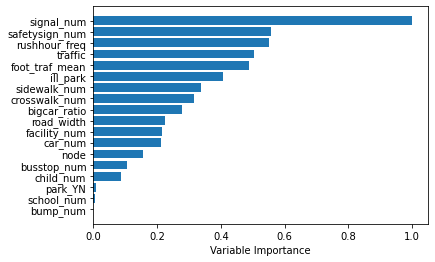

In [410]:
featureImportance = regressor.feature_importances_
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, X_train_rf.columns[sorted_idx])
plt.xlabel('Variable Importance')
plt.show()

In [411]:
predictions_rf = pd.DataFrame(data = y_pred, columns = ['predictions_rf'])
final2 = pd.concat([final2,predictions_rf],axis=1)
final2

,gid,geometry,accident_cnt,predictions_gwr,predictions_rf
0,다사621060,"MULTIPOLYGON (((127.07319 37.15196, 127.07319 ...",1,0.653912,0.670084
1,다사626065,"MULTIPOLYGON (((127.07880 37.15648, 127.07879 ...",2,0.381914,0.584464
2,다사616062,"MULTIPOLYGON (((127.06755 37.15374, 127.06755 ...",1,0.527531,0.777160
3,다사602048,"MULTIPOLYGON (((127.05186 37.14106, 127.05186 ...",1,0.732804,0.914054
4,다사628040,"MULTIPOLYGON (((127.08118 37.13396, 127.08117 ...",2,0.250634,0.251109
...,...,...,...,...,...
271,다사588072,"MULTIPOLYGON (((127.03597 37.16263, 127.03596 ...",0,0.154843,0.182074
272,다사611102,"MULTIPOLYGON (((127.06171 37.18978, 127.06171 ...",0,0.135390,0.052456
273,다사609082,"MULTIPOLYGON (((127.05956 37.17174, 127.05956 ...",0,1.414197,1.316412
274,다사584113,"MULTIPOLYGON (((127.03123 37.19957, 127.03123 ...",0,0.049469,0.076681


# Light GBM

### 1. Train, Test data

In [412]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1104, 23) (1104, 1) (276, 22) (276, 1)


In [413]:
X_train_lgb = X_train.drop(['gid','lat','lon','for_split','geometry'],axis=1)
y_train_lgb = y_train
X_test_lgb = X_test.drop(['gid','lat','lon','geometry'],axis=1)
y_test_lgb = y_test
print(X_train_lgb.shape, y_train_lgb.shape, X_test_lgb.shape, y_test_lgb.shape)

(1104, 18) (1104, 1) (276, 18) (276, 1)


In [414]:
feature_names = X_test_lgb.columns
feature_names

Index(['safetysign_num', 'bump_num', 'child_num', 'school_num', 'facility_num',
       'signal_num', 'busstop_num', 'crosswalk_num', 'sidewalk_num',
       'ill_park', 'car_num', 'node', 'park_YN', 'foot_traf_mean', 'traffic',
       'bigcar_ratio', 'rushhour_freq', 'road_width'],
      dtype='object')

### 2. Scaling

In [415]:
sc = StandardScaler()
X_train_lgb = sc.fit_transform(X_train_lgb)
X_test_lgb = sc.transform(X_test_lgb)
X_train_lgb = pd.DataFrame(X_train_lgb, columns = feature_names)
X_test_lgb = pd.DataFrame(X_test_lgb, columns = feature_names)
X_train_lgb.columns

Index(['safetysign_num', 'bump_num', 'child_num', 'school_num', 'facility_num',
       'signal_num', 'busstop_num', 'crosswalk_num', 'sidewalk_num',
       'ill_park', 'car_num', 'node', 'park_YN', 'foot_traf_mean', 'traffic',
       'bigcar_ratio', 'rushhour_freq', 'road_width'],
      dtype='object')

In [416]:
train_ds = lgb.Dataset(X_train_lgb,label = y_train_lgb)
test_ds = lgb.Dataset(X_train_lgb,label=y_train_lgb)
params = {'learning rate':0.01,
          'boosting':'gbdt',
          'objective':'regression',
          'metric':'mse',
          'is_training_metric':True,
          'bagging_fraction': 0.7,
          'feature_fraction': 0.9,
          'max_depth': 20,
          'min_child_weight': 22,
          'min_split_gain': 0.1,
          'num_leaves': 144,
          'bagging_freq':5,
          'seed':20210122}

model = lgb.train(params,train_ds,1000,test_ds,verbose_eval = 100,early_stopping_rounds=100)

[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 1104, number of used features: 17
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Info] Start training from score 0.326993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

In [417]:
y_pred = model.predict(X_test_lgb)
mse = mean_squared_error(y_test_lgb, y_pred)
rmse = np.sqrt(mse)
msle = mean_squared_log_error(y_test_lgb, y_pred + 1)
rmsle = np.sqrt(msle)
print(y_pred)
print('Mean Squared Error :', mse)
print('Root Mean Squared Error :', rmse)
print('Mean Squared Log Error :', msle)
print('Root Mean Squared Log Error :', rmsle)

[ 1.32483413e+00  3.17403066e-01  8.33854052e-01  5.94538854e-01
  4.28049754e-02 -1.61480405e-01  5.58597140e-01  4.07675598e-01
  1.47870626e+00  3.85642206e-01  8.14929243e-01  3.88941711e-02
  4.82439206e-02  3.96154281e-01  7.28718036e-03  1.15466376e+00
  1.13234407e-03  1.34272685e-01  6.20891876e-01  9.38350814e-01
 -3.16562296e-02  2.51223749e-01  5.85384471e-02 -7.24590013e-02
  1.80655526e-01  6.29780023e-01  3.04580187e-02  1.09055597e+00
 -3.65292947e-02  2.11203104e-01  9.13496386e-01  2.69385267e-01
  3.38714500e+00 -2.49444088e-01  2.43810867e-01  3.94965480e+00
 -1.13221140e-02  1.29894031e-01  5.31805889e-01  9.57231249e-01
 -1.54086070e-02  2.11707825e-01  2.83676274e-01  3.57210725e-01
 -2.73714018e-01  1.22168671e+00  1.71030541e-01  8.25173003e-02
  1.21715776e-01 -7.60591109e-04  1.62372167e-01  1.01313313e+00
  3.48620755e+00  6.31949622e-01  9.79086104e-01 -2.50185602e-02
  5.97437711e-01 -6.48969991e-02  1.15200669e-01  3.07822004e-02
  7.86661915e-02 -4.29286

In [418]:
final_result = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(y_pred)], axis = 1)
final_result.columns = ['Label','Prediction']
print(final_result)

     Label  Prediction
0        1    1.324834
1        2    0.317403
2        1    0.833854
3        1    0.594539
4        2    0.042805
..     ...         ...
271      0    0.469837
272      0    0.057064
273      0    1.124513
274      0    0.046794
275      0   -0.187467

[276 rows x 2 columns]


<AxesSubplot:xlabel='Label', ylabel='Prediction'>

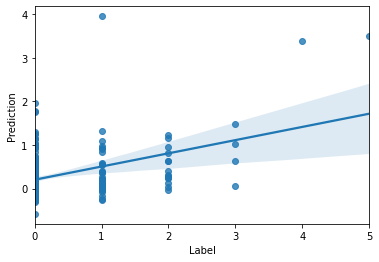

In [419]:
sns.regplot(x = 'Label', y = 'Prediction', data = final_result)

In [420]:
print('Feature names:', model.feature_name())

Feature names: ['safetysign_num', 'bump_num', 'child_num', 'school_num', 'facility_num', 'signal_num', 'busstop_num', 'crosswalk_num', 'sidewalk_num', 'ill_park', 'car_num', 'node', 'park_YN', 'foot_traf_mean', 'traffic', 'bigcar_ratio', 'rushhour_freq', 'road_width']


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

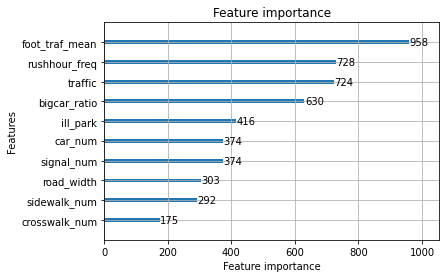

In [421]:
lgb.plot_importance(model, max_num_features=10)

In [422]:
predictions_lgbm = pd.DataFrame(data = y_pred, columns = ['predictions_lgbm'])
final2 = pd.concat([final2,predictions_lgbm],axis=1)
final2

,gid,geometry,accident_cnt,predictions_gwr,predictions_rf,predictions_lgbm
0,다사621060,"MULTIPOLYGON (((127.07319 37.15196, 127.07319 ...",1,0.653912,0.670084,1.324834
1,다사626065,"MULTIPOLYGON (((127.07880 37.15648, 127.07879 ...",2,0.381914,0.584464,0.317403
2,다사616062,"MULTIPOLYGON (((127.06755 37.15374, 127.06755 ...",1,0.527531,0.777160,0.833854
3,다사602048,"MULTIPOLYGON (((127.05186 37.14106, 127.05186 ...",1,0.732804,0.914054,0.594539
4,다사628040,"MULTIPOLYGON (((127.08118 37.13396, 127.08117 ...",2,0.250634,0.251109,0.042805
...,...,...,...,...,...,...
271,다사588072,"MULTIPOLYGON (((127.03597 37.16263, 127.03596 ...",0,0.154843,0.182074,0.469837
272,다사611102,"MULTIPOLYGON (((127.06171 37.18978, 127.06171 ...",0,0.135390,0.052456,0.057064
273,다사609082,"MULTIPOLYGON (((127.05956 37.17174, 127.05956 ...",0,1.414197,1.316412,1.124513
274,다사584113,"MULTIPOLYGON (((127.03123 37.19957, 127.03123 ...",0,0.049469,0.076681,0.046794


# Score for no child

In [34]:
dataset_num = dataset_nochild.drop(columns=["accident_cnt","gid","geometry","lat","lon"])
dataset_num

,safetysign_num,bump_num,child_num,school_num,facility_num,signal_num,busstop_num,crosswalk_num,sidewalk_num,ill_park,car_num,node,park_YN,foot_traf_mean,traffic,bigcar_ratio,rushhour_freq,road_width
0,1,0,0.0,0,0,0,0,0,0,0,0,1,0,42.714375,4779.710000,0.232100,4.6300,0.500
1,0,0,0.0,0,0,0,0,0,0,0,0,1,0,17.366065,2982.066667,0.338792,35.0050,0.500
2,1,0,0.0,0,0,0,0,0,0,0,1,0,1,27.409931,4835.990000,0.232096,5.2850,0.500
3,0,0,0.0,0,0,0,0,0,0,0,0,0,1,7.110000,4835.990000,0.232096,5.2850,0.500
4,0,0,0.0,0,0,0,0,0,0,0,3,0,0,11.820111,1607.680000,0.372530,99.7800,0.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,0,0,0.0,0,0,0,0,0,2,5,0,0,0,2.442500,1936.405000,0.117912,29.0625,0.625
1376,0,0,0.0,0,0,0,0,0,2,77,0,0,0,171.749722,2293.930000,0.057351,19.6000,0.500
1377,0,0,0.0,0,0,0,0,0,2,4,0,0,0,0.000000,2293.930000,0.057351,19.6000,0.500
1378,0,0,0.0,0,0,0,0,0,2,9,0,1,0,9.059167,1578.880000,0.178473,38.5250,0.750


In [35]:
dataset_num_scaled = minmax_scale(dataset_num,axis=0)
dataset_num_scaled = pd.DataFrame(dataset_num_scaled)
dataset_num_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.2,0.0,0.038659,0.167040,0.445251,0.046300,0.333333
1,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.2,0.0,0.015717,0.102876,0.655362,0.350050,0.333333
2,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000333,0.0,1.0,0.024808,0.169048,0.445242,0.052850,0.333333
3,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.006435,0.169048,0.445242,0.052850,0.333333
4,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000999,0.0,0.0,0.010698,0.053820,0.721803,0.997800,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133333,0.001167,0.000000,0.0,0.0,0.002211,0.065554,0.220376,0.290625,0.500000
1376,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133333,0.017974,0.000000,0.0,0.0,0.155444,0.078315,0.101113,0.196000,0.333333
1377,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133333,0.000934,0.000000,0.0,0.0,0.000000,0.078315,0.101113,0.196000,0.333333
1378,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133333,0.002101,0.000000,0.2,0.0,0.008199,0.052792,0.339640,0.385250,0.666667


In [36]:
dataset_num_scaled.columns = dataset_num.columns
dataset_num_scaled.columns

Index(['safetysign_num', 'bump_num', 'child_num', 'school_num', 'facility_num',
       'signal_num', 'busstop_num', 'crosswalk_num', 'sidewalk_num',
       'ill_park', 'car_num', 'node', 'park_YN', 'foot_traf_mean', 'traffic',
       'bigcar_ratio', 'rushhour_freq', 'road_width'],
      dtype='object')

In [37]:
w1 = [60, 0, 0, 0, 0, 100, 0, 0, 0, 40, 0, 0, 0, 50, 50, -20, 60, 0]

risk1 = []

In [38]:
for i in range(len(dataset_num_scaled)):
    risk1.append(sum(np.array(dataset_num_scaled.iloc[i,:]*w1)))
risk1

[19.157923277187614,
 13.825451155989473,
 18.958970468055565,
 3.040335582015925,
 48.657849782763435,
 17.271121286867174,
 38.44223389767697,
 9.489517194173688,
 0.8245320094429323,
 46.77095704350799,
 33.91785587729721,
 42.213455573017775,
 41.884305700673956,
 18.423906853730525,
 7.4846023581182495,
 58.511471987665665,
 53.43191173580014,
 56.96031142494367,
 27.28602102242604,
 28.29647064279745,
 28.53121964608397,
 14.939871803036187,
 11.029581379206393,
 25.99795314252297,
 28.42481385323952,
 32.24400042994584,
 43.767558146002095,
 37.42371359998704,
 16.20537880860964,
 65.17357285616475,
 92.88487878410837,
 12.33814724654563,
 132.05223825957995,
 7.895527388881257,
 110.95746859530588,
 26.77423750154712,
 19.08574537765919,
 41.97634670398771,
 43.15536372174648,
 17.58117391843417,
 19.714385416863816,
 3.1365178383182606,
 24.392159655049895,
 24.372064217207303,
 79.12885015911608,
 56.47280218212548,
 34.12624925543015,
 111.09929895257619,
 53.21417469267036,

In [39]:
score1 = pd.concat([dataset_nochild,pd.DataFrame({"risk1":risk1})],axis=1)
score1 = score1[["gid","geometry","accident_cnt","risk1"]]
score1

,gid,geometry,accident_cnt,risk1
0,다사564096,"MULTIPOLYGON (((127.00880 37.18416, 127.00879 ...",1,19.157923
1,다사569091,"MULTIPOLYGON (((127.01446 37.17968, 127.01445 ...",0,13.825451
2,다사569092,"MULTIPOLYGON (((127.01445 37.18058, 127.01445 ...",0,18.958970
3,다사569093,"MULTIPOLYGON (((127.01445 37.18148, 127.01444 ...",0,3.040336
4,다사570088,"MULTIPOLYGON (((127.01560 37.17698, 127.01559 ...",0,48.657850
...,...,...,...,...
1375,다사640065,"MULTIPOLYGON (((127.09457 37.15654, 127.09456 ...",0,16.464863
1376,다사640066,"MULTIPOLYGON (((127.09456 37.15744, 127.09456 ...",0,22.144641
1377,다사640067,"MULTIPOLYGON (((127.09456 37.15834, 127.09455 ...",0,13.690827
1378,다사641063,"MULTIPOLYGON (((127.09570 37.15474, 127.09570 ...",0,19.455804


In [40]:
score1 = score1.sort_values(by='risk1',ascending=False)
score1.iloc[0:29]

,gid,geometry,accident_cnt,risk1
1107,다사621056,"MULTIPOLYGON (((127.07321 37.14835, 127.07321 ...",5,207.270924
1099,다사621048,"MULTIPOLYGON (((127.07325 37.14114, 127.07325 ...",10,203.847652
1160,다사623056,"MULTIPOLYGON (((127.07547 37.14836, 127.07546 ...",2,187.001019
1104,다사621053,"MULTIPOLYGON (((127.07323 37.14565, 127.07322 ...",3,175.863726
759,다사610079,"MULTIPOLYGON (((127.06071 37.16904, 127.06070 ...",1,173.213627
1070,다사620042,"MULTIPOLYGON (((127.07216 37.13573, 127.07215 ...",7,171.287842
1214,다사625064,"MULTIPOLYGON (((127.07768 37.15558, 127.07767 ...",3,168.186062
362,다사595087,"MULTIPOLYGON (((127.04377 37.17619, 127.04376 ...",4,167.076939
749,다사610057,"MULTIPOLYGON (((127.06082 37.14921, 127.06082 ...",5,166.530490
371,다사595101,"MULTIPOLYGON (((127.04369 37.18881, 127.04369 ...",0,157.200846


### Score Graph

In [51]:
#risk 정보 데이터와 기존 dataset 통합
score_merge = pd.merge(dataset_nochild,score1.iloc[:, [0,3]], on='gid')
score_column_list = ['safetysign_num','signal_num','ill_park','foot_traf_mean', 'traffic', 'bigcar_ratio', 'rushhour_freq']

In [ ]:
#risk 정도에 따라 안전, 주의, 위험 지역으로 구분
#0 ~ 50: 안전, 50~100: 주의, 100~: 위험

bins = [0, 50, 100, math.inf]
label = ['안전', '주의', '위험']
test = pd.cut(score_merge['risk1'], bins, right = False, labels = label)
score_merge['위험도'] = test

In [55]:
#안전 주의 위험에 따른 dataset 생성
안전지역 = score_merge[score_merge['위험도']=='안전']
주의지역 = score_merge[score_merge['위험도']=='주의']
위험지역 = score_merge[score_merge['위험도']=='위험']

In [63]:
안전_json = 안전지역.to_json()
주의_json = 주의지역.to_json()
위험_json = 위험지역.to_json()


#map 기본 정보
m = folium.Map(
    location = [37.16323633764299, 127.05128286756862],
    zoom_start=14
)


#map 타일추가
folium.TileLayer('http://api.vworld.kr/req/wmts/1.0.0/A0D28BDF-548E-38C9-BFE4-ACBC9CF80602/Satellite/{z}/{y}/{x}.jpeg',
                 attr='오산시',
                 name='실사지도').add_to(m)


#안전, 주의, 위험에 따라 그룹
fg = folium.FeatureGroup(name='전체')
g1 = plugins.FeatureGroupSubGroup(fg, '안전')
g2 = plugins.FeatureGroupSubGroup(fg, '주의')
g3 = plugins.FeatureGroupSubGroup(fg, '위험')

m.add_child(fg)
m.add_child(g1)
m.add_child(g2)
m.add_child(g3)


#안전, 주의, 위험 각 지역 위치 정보 mapping
choro1 = folium.Choropleth(
    geo_data=안전_json,
    fill_color = 'green'
)

choro1.add_to(g1)

choro2 = folium.Choropleth(
    geo_data=주의_json,
    fill_color = 'orange'
)

choro2.add_to(g2)

choro3 = folium.Choropleth(
    geo_data=위험_json,
    fill_color = 'red'
)

choro3.add_to(g3)


#검색창
plugins.Search(layer = fg,
              geom_type = 'Polygon',
              search_label = 'gid',
              search_zoom = 17
              ).add_to(m)



#Popup창 뜨게 하기
choro1.geojson.add_child(
    folium.features.GeoJsonTooltip(score_column_list, labels = True)
)
choro2.geojson.add_child(
    folium.features.GeoJsonTooltip(score_column_list, labels = True)
)
choro3.geojson.add_child(
    folium.features.GeoJsonTooltip(score_column_list, labels = True)
)

#마우스 올렸을 때 오른쪽 위에 좌표 생성
formatter = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"

plugins.MousePosition(
    position='topright',
    separator=' | ',
    empty_string='NaN',
    lng_first=True,
    num_digits=20,
    prefix='Coordinates:',
    lat_formatter=formatter,
    lng_formatter=formatter,
).add_to(m)



#오른쪽 상단에 그룹 control창 생성
folium.LayerControl(collapsed=False).add_to(m)


m

# Dataset for child

어린이 보호구역 내의 데이터(해당 격자 내 School zone의 숫자가 1이상이면 해당 구역을 어린이 보호구역으로 놓았다)

In [4]:
dataset = pd.read_csv('dataset2.txt', delimiter = '\t')
dataset_child = dataset[dataset['schoolzone_num']>0]
dataset_child = dataset_child.drop(['Unnamed: 0', 'geometry'], axis=1)
GetCompasData('SBJ_2012_001', '2', '2.오산시_어린이교통사고_격자.geojson')
data2 = gpd.read_file('2.오산시_어린이교통사고_격자.geojson')
del data2['accident_cnt']
dataset_child = pd.merge(dataset_child, data2, on='gid')
dataset_child

,gid,accident_cnt,schoolzone_num,safetysign_num,bump_num,child_num,school_num,facility_num,signal_num,busstop_num,...,ill_park,car_num,node,park_YN,foot_traf_mean,traffic,bigcar_ratio,rushhour_freq,road_width,geometry
0,다사571088,0,1,0,0,0.0,0,0,0,0,...,0,14,1,0,10.848201,1542.707500,0.362590,81.262500,0.375000,"MULTIPOLYGON (((127.01673 37.17698, 127.01672 ..."
1,다사578109,0,1,0,0,6.0,0,0,0,0,...,0,36,0,0,16.517292,14931.657500,0.190651,23.547500,0.750000,"MULTIPOLYGON (((127.02449 37.19594, 127.02449 ..."
2,다사579109,0,1,1,0,0.0,0,0,0,0,...,0,7,0,0,31.879167,12951.074000,0.189168,22.230000,0.650000,"MULTIPOLYGON (((127.02562 37.19595, 127.02561 ..."
3,다사580079,0,1,0,0,0.0,1,0,1,0,...,0,0,0,0,11.574640,2316.091667,0.276260,55.203333,0.666667,"MULTIPOLYGON (((127.02692 37.16891, 127.02691 ..."
4,다사580080,0,1,0,0,0.0,0,0,4,2,...,10,0,0,0,7.814555,2324.453333,0.274590,38.578333,0.666667,"MULTIPOLYGON (((127.02691 37.16981, 127.02690 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,다사631037,0,1,0,0,0.0,0,0,0,0,...,3,0,0,0,74.561528,2062.535000,0.240368,38.630000,0.750000,"MULTIPOLYGON (((127.08457 37.13127, 127.08456 ..."
203,다사631038,2,2,1,0,0.0,0,9,6,1,...,4,3,2,0,558.219290,7243.236000,0.188602,84.665000,0.650000,"MULTIPOLYGON (((127.08456 37.13217, 127.08456 ..."
204,다사631039,0,1,0,0,0.0,2,0,0,1,...,1,0,0,0,125.854896,12874.070000,0.174209,99.575000,0.750000,"MULTIPOLYGON (((127.08456 37.13307, 127.08455 ..."
205,다사637059,0,1,0,0,106.0,0,0,4,0,...,13,0,0,0,27.253655,4843.490000,0.222945,54.360000,0.750000,"MULTIPOLYGON (((127.09122 37.15112, 127.09121 ..."


In [5]:
dataset_child = gpd.GeoDataFrame(dataset_child, geometry = dataset_child.geometry)
center = dataset_child.geometry.centroid
center = pd.DataFrame(data = center, columns = ['center'])
dataset_child = pd.concat((dataset_child, center), axis=1)
dataset_child.set_crs(epsg=4326, inplace=True)
dataset_child['lat'] = dataset_child['center'].apply(lambda coord: coord.y)
dataset_child['lon'] = dataset_child['center'].apply(lambda coord: coord.x)
del dataset_child['center']
dataset_child

,gid,accident_cnt,schoolzone_num,safetysign_num,bump_num,child_num,school_num,facility_num,signal_num,busstop_num,...,node,park_YN,foot_traf_mean,traffic,bigcar_ratio,rushhour_freq,road_width,geometry,lat,lon
0,다사571088,0,1,0,0,0.0,0,0,0,0,...,1,0,10.848201,1542.707500,0.362590,81.262500,0.375000,"MULTIPOLYGON (((127.01673 37.17698, 127.01672 ...",37.177434,127.017287
1,다사578109,0,1,0,0,6.0,0,0,0,0,...,0,0,16.517292,14931.657500,0.190651,23.547500,0.750000,"MULTIPOLYGON (((127.02449 37.19594, 127.02449 ...",37.196394,127.025054
2,다사579109,0,1,1,0,0.0,0,0,0,0,...,0,0,31.879167,12951.074000,0.189168,22.230000,0.650000,"MULTIPOLYGON (((127.02562 37.19595, 127.02561 ...",37.196399,127.026181
3,다사580079,0,1,0,0,0.0,1,0,1,0,...,0,0,11.574640,2316.091667,0.276260,55.203333,0.666667,"MULTIPOLYGON (((127.02692 37.16891, 127.02691 ...",37.169362,127.027476
4,다사580080,0,1,0,0,0.0,0,0,4,2,...,0,0,7.814555,2324.453333,0.274590,38.578333,0.666667,"MULTIPOLYGON (((127.02691 37.16981, 127.02690 ...",37.170263,127.027471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,다사631037,0,1,0,0,0.0,0,0,0,0,...,0,0,74.561528,2062.535000,0.240368,38.630000,0.750000,"MULTIPOLYGON (((127.08457 37.13127, 127.08456 ...",37.131718,127.085128
203,다사631038,2,2,1,0,0.0,0,9,6,1,...,2,0,558.219290,7243.236000,0.188602,84.665000,0.650000,"MULTIPOLYGON (((127.08456 37.13217, 127.08456 ...",37.132620,127.085123
204,다사631039,0,1,0,0,0.0,2,0,0,1,...,0,0,125.854896,12874.070000,0.174209,99.575000,0.750000,"MULTIPOLYGON (((127.08456 37.13307, 127.08455 ...",37.133521,127.085118
205,다사637059,0,1,0,0,106.0,0,0,4,0,...,0,0,27.253655,4843.490000,0.222945,54.360000,0.750000,"MULTIPOLYGON (((127.09122 37.15112, 127.09121 ...",37.151573,127.091776


어린이 보호구역 내 데이터의 열 이름

In [6]:
dataset_child.columns

Index(['gid', 'accident_cnt', 'schoolzone_num', 'safetysign_num', 'bump_num',
       'child_num', 'school_num', 'facility_num', 'signal_num', 'busstop_num',
       'crosswalk_num', 'sidewalk_num', 'ill_park', 'car_num', 'node',
       'park_YN', 'foot_traf_mean', 'traffic', 'bigcar_ratio', 'rushhour_freq',
       'road_width', 'geometry', 'lat', 'lon'],
      dtype='object')

어린이 보호구역 내 데이터의 상관관계

In [7]:
corr = dataset_child.drop(['gid','geometry','lat','lon'],axis=1).corr()
corr.style.background_gradient(cmap='coolwarm')

,accident_cnt,schoolzone_num,safetysign_num,bump_num,child_num,school_num,facility_num,signal_num,busstop_num,crosswalk_num,sidewalk_num,ill_park,car_num,node,park_YN,foot_traf_mean,traffic,bigcar_ratio,rushhour_freq,road_width
accident_cnt,1.000000,0.021084,0.461411,0.028534,0.068146,0.040732,0.081546,0.301889,0.235045,0.253698,0.095896,0.109659,-0.046431,0.107927,-0.060699,0.226499,0.081363,-0.060814,0.037800,0.113292
schoolzone_num,0.021084,1.000000,-0.079221,0.089103,-0.026534,0.088085,0.103158,0.240656,0.009267,0.274507,0.097264,0.021530,0.008887,0.017095,0.126077,-0.021353,0.053385,-0.075222,0.073533,-0.118312
safetysign_num,0.461411,-0.079221,1.000000,-0.042550,-0.037355,-0.037538,-0.041201,0.365494,0.224594,0.264212,0.214941,0.006384,-0.082986,0.098595,-0.044989,0.241460,0.199045,0.065227,-0.104872,0.206152
bump_num,0.028534,0.089103,-0.042550,1.000000,-0.064675,0.208737,0.101774,-0.059555,-0.050969,0.006946,0.008035,0.350408,-0.003049,0.079642,-0.002425,0.030493,-0.062874,-0.134124,-0.010508,-0.109568
child_num,0.068146,-0.026534,-0.037355,-0.064675,1.000000,0.174393,0.038765,0.123357,0.023914,0.074124,-0.049844,0.024489,0.265542,0.006812,-0.042787,0.112598,-0.167859,-0.030236,0.151246,-0.105903
school_num,0.040732,0.088085,-0.037538,0.208737,0.174393,1.000000,0.049950,-0.102791,-0.077666,-0.091828,-0.134094,0.044950,0.067405,-0.103692,-0.019386,0.095245,0.055924,-0.167898,0.019309,0.028921
facility_num,0.081546,0.103158,-0.041201,0.101774,0.038765,0.049950,1.000000,-0.000465,0.047596,0.141888,0.004498,0.569631,0.022457,0.090361,0.197480,0.083828,0.056211,-0.129104,0.120294,-0.000424
signal_num,0.301889,0.240656,0.365494,-0.059555,0.123357,-0.102791,-0.000465,1.000000,0.308120,0.611087,0.482971,-0.008940,-0.041915,0.091120,0.091666,0.139042,0.045531,0.058813,-0.152008,0.207874
busstop_num,0.235045,0.009267,0.224594,-0.050969,0.023914,-0.077666,0.047596,0.308120,1.000000,0.308231,0.051591,0.029679,-0.091964,0.116966,-0.131359,0.326114,0.125293,0.076795,-0.062355,0.133914
crosswalk_num,0.253698,0.274507,0.264212,0.006946,0.074124,-0.091828,0.141888,0.611087,0.308231,1.000000,0.399775,0.127544,-0.058826,0.223926,0.218479,0.142511,0.017926,0.124280,-0.011718,0.147234


### Split train and test data

어린이 보호구역 내의 데이터를 train data와 test data로 나눌 때, 어린이 보호구역 내에서 사고가 있었던 지역의 데이터 중 80%는 train data, 20%는 test data로 하였다. 마찬가지로 어린이 보호구역 내에서 사고가 한 건도 발생하지 않은 지역의 데이터 중 80%는 train data, 20%는 test data로 하였다. 이번 프로젝트에서 GWR, Random Forest, Light GBM 총 3개의 모델을 사용하였는데, train, test data는 동일하게 놓고 모델링을 진행하였다.

In [8]:
dataset1 = dataset_child[dataset_child['accident_cnt']>0]
dataset1 = dataset1.reset_index(drop=True)
dataset1['for_split'] = 1 #구분을 위해 만든 변수(의미 포함 X)
dataset1

,gid,accident_cnt,schoolzone_num,safetysign_num,bump_num,child_num,school_num,facility_num,signal_num,busstop_num,...,park_YN,foot_traf_mean,traffic,bigcar_ratio,rushhour_freq,road_width,geometry,lat,lon,for_split
0,다사591095,1,1,0,0,0.0,2,0,0,0,...,0,95.546771,6664.640000,0.113610,1.360000,0.500000,"MULTIPOLYGON (((127.03922 37.18338, 127.03921 ...",37.183833,127.039779,1
1,다사595085,3,1,1,0,125.0,0,0,9,2,...,0,191.681354,3054.050000,0.226240,52.601667,0.666667,"MULTIPOLYGON (((127.04378 37.17438, 127.04377 ...",37.174836,127.044339,1
2,다사595090,1,1,0,0,0.0,0,0,0,0,...,0,92.903958,4194.607500,0.207679,41.327500,0.750000,"MULTIPOLYGON (((127.04375 37.17889, 127.04375 ...",37.179343,127.044312,1
3,다사595096,1,1,0,0,0.0,0,0,0,0,...,0,12.718281,1309.328500,0.232856,74.490500,0.500000,"MULTIPOLYGON (((127.04372 37.18430, 127.04371 ...",37.184752,127.044280,1
4,다사600051,1,1,0,0,0.0,0,0,1,0,...,0,34.603341,4252.000000,0.118186,99.610000,0.500000,"MULTIPOLYGON (((127.04959 37.14376, 127.04959 ...",37.144211,127.050153,1
5,다사601053,1,1,0,0,24.0,0,0,0,0,...,0,48.272557,702.270000,0.066179,62.355000,0.500000,"MULTIPOLYGON (((127.05071 37.14556, 127.05070 ...",37.146018,127.051268,1
6,다사604086,1,1,2,0,0.0,1,0,6,0,...,1,64.101354,5734.082000,0.090111,38.307000,0.900000,"MULTIPOLYGON (((127.05391 37.17532, 127.05391 ...",37.175776,127.054472,1
7,다사605070,2,1,0,0,25.0,1,7,0,0,...,0,108.297917,1234.868333,0.060428,76.990000,0.500000,"MULTIPOLYGON (((127.05512 37.16091, 127.05512 ...",37.161358,127.055683,1
8,다사605080,1,1,0,0,0.0,1,0,0,0,...,0,21.870208,9353.760000,0.145589,4.935000,1.000000,"MULTIPOLYGON (((127.05507 37.16992, 127.05506 ...",37.170372,127.055630,1
9,다사606070,1,2,0,3,0.0,2,5,0,0,...,0,39.895521,1190.740000,0.051148,58.530000,0.250000,"MULTIPOLYGON (((127.05625 37.16091, 127.05624 ...",37.161363,127.056809,1


In [9]:
dataset2 = dataset_child[dataset_child['accident_cnt']==0]
dataset2 = dataset2.reset_index(drop=True)
dataset2['for_split'] = 0 #구분을 위해 만든 변수(의미 포함 X)
dataset2

,gid,accident_cnt,schoolzone_num,safetysign_num,bump_num,child_num,school_num,facility_num,signal_num,busstop_num,...,park_YN,foot_traf_mean,traffic,bigcar_ratio,rushhour_freq,road_width,geometry,lat,lon,for_split
0,다사571088,0,1,0,0,0.0,0,0,0,0,...,0,10.848201,1542.707500,0.362590,81.262500,0.375000,"MULTIPOLYGON (((127.01673 37.17698, 127.01672 ...",37.177434,127.017287,0
1,다사578109,0,1,0,0,6.0,0,0,0,0,...,0,16.517292,14931.657500,0.190651,23.547500,0.750000,"MULTIPOLYGON (((127.02449 37.19594, 127.02449 ...",37.196394,127.025054,0
2,다사579109,0,1,1,0,0.0,0,0,0,0,...,0,31.879167,12951.074000,0.189168,22.230000,0.650000,"MULTIPOLYGON (((127.02562 37.19595, 127.02561 ...",37.196399,127.026181,0
3,다사580079,0,1,0,0,0.0,1,0,1,0,...,0,11.574640,2316.091667,0.276260,55.203333,0.666667,"MULTIPOLYGON (((127.02692 37.16891, 127.02691 ...",37.169362,127.027476,0
4,다사580080,0,1,0,0,0.0,0,0,4,2,...,0,7.814555,2324.453333,0.274590,38.578333,0.666667,"MULTIPOLYGON (((127.02691 37.16981, 127.02690 ...",37.170263,127.027471,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,다사630044,0,1,0,0,0.0,0,0,0,0,...,0,16.962292,2707.383333,0.207024,52.475000,0.500000,"MULTIPOLYGON (((127.08341 37.13757, 127.08340 ...",37.138024,127.083968,0
156,다사631037,0,1,0,0,0.0,0,0,0,0,...,0,74.561528,2062.535000,0.240368,38.630000,0.750000,"MULTIPOLYGON (((127.08457 37.13127, 127.08456 ...",37.131718,127.085128,0
157,다사631039,0,1,0,0,0.0,2,0,0,1,...,0,125.854896,12874.070000,0.174209,99.575000,0.750000,"MULTIPOLYGON (((127.08456 37.13307, 127.08455 ...",37.133521,127.085118,0
158,다사637059,0,1,0,0,106.0,0,0,4,0,...,0,27.253655,4843.490000,0.222945,54.360000,0.750000,"MULTIPOLYGON (((127.09122 37.15112, 127.09121 ...",37.151573,127.091776,0


In [10]:
X1 = dataset1.drop(['accident_cnt'],axis=1)
y1 = dataset1.accident_cnt
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.20, random_state=4)
X2 = dataset2.drop(['accident_cnt'],axis=1)
y2 = dataset2.accident_cnt
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=4)

In [11]:
X_train = pd.concat([X1_train,X2_train])
X_train = X_train.reset_index()
X_train = X_train.drop(['index'],axis=1)
X_test = pd.concat([X1_test,X2_test])
X_test = X_test.reset_index()
X_test = X_test.drop(['index','for_split'],axis=1)
y_train = pd.concat([y1_train,y2_train])
y_train = y_train.reset_index()
y_train = y_train.drop(['index'],axis=1)
y_test = pd.concat([y1_test,y2_test])
y_test = y_test.reset_index()
y_test = y_test.drop(['index'],axis=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(165, 24) (165, 1) (42, 23) (42, 1)


# GWR

### 1. Train, Test data

In [463]:
X_train_gwr = X_train
y_train_gwr = y_train
X_test_gwr = X_test
y_test_gwr = y_test
print(X_train_gwr.shape, y_train_gwr.shape, X_test_gwr.shape, y_test_gwr.shape)

(165, 24) (165, 1) (42, 23) (42, 1)


In [464]:
X_train_gwr

,gid,schoolzone_num,safetysign_num,bump_num,child_num,school_num,facility_num,signal_num,busstop_num,crosswalk_num,...,park_YN,foot_traf_mean,traffic,bigcar_ratio,rushhour_freq,road_width,geometry,lat,lon,for_split
0,다사617061,2,0,0,0.0,0,1,0,0,2,...,0,103.875208,632.761667,0.113479,91.230833,0.333333,"MULTIPOLYGON (((127.06868 37.15284, 127.06868 ...",37.153296,127.069244,1
1,다사624065,1,0,0,7.0,0,0,0,0,0,...,0,276.906146,413.839091,0.091761,97.768182,0.500000,"MULTIPOLYGON (((127.07655 37.15648, 127.07654 ...",37.156930,127.077107,1
2,다사608081,1,0,1,7.0,0,4,0,0,5,...,0,179.684536,1509.775000,0.079620,76.044286,0.607143,"MULTIPOLYGON (((127.05844 37.17083, 127.05844 ...",37.171286,127.059004,1
3,다사627048,1,0,0,0.0,0,0,0,0,0,...,0,2.213344,1436.855000,0.189025,54.395000,0.375000,"MULTIPOLYGON (((127.08001 37.14117, 127.08000 ...",37.141618,127.080570,1
4,다사619035,2,0,0,0.0,0,4,1,0,6,...,0,71.556458,10518.382857,0.202921,95.215714,0.535714,"MULTIPOLYGON (((127.07107 37.12941, 127.07106 ...",37.129868,127.071628,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,다사604046,1,0,0,0.0,0,0,2,0,3,...,0,21.340979,7812.565000,0.149151,56.460000,1.000000,"MULTIPOLYGON (((127.05412 37.13927, 127.05412 ...",37.139721,127.054684,0
161,다사617057,1,0,0,0.0,1,1,0,0,1,...,0,230.703438,632.761667,0.113479,91.230833,0.333333,"MULTIPOLYGON (((127.06870 37.14924, 127.06870 ...",37.149690,127.069264,0
162,다사619039,2,0,0,130.0,1,0,0,1,2,...,0,152.166146,1416.236667,0.145392,76.546667,0.500000,"MULTIPOLYGON (((127.07105 37.13302, 127.07104 ...",37.133473,127.071608,0
163,다사623050,1,0,0,0.0,2,0,0,0,0,...,0,156.754063,9952.140000,0.286205,36.180000,1.000000,"MULTIPOLYGON (((127.07550 37.14295, 127.07549 ...",37.143405,127.076056,0


분석에 필요한 19개의 변수들만 사용하였다. 어린이 보호구역 외의 데이터와 달리, school zone의 개수를 나타내는 schoolzone_num 변수를 포함하였다.

In [465]:
x_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
X_train_gwr = X_train.iloc[:, x_list]
X_test_gwr_gid = X_test_gwr.gid
X_test_gwr_geo = X_test_gwr.geometry
X_test_gwr = X_test.iloc[:, x_list]
X_train_gwr

,schoolzone_num,safetysign_num,bump_num,child_num,school_num,facility_num,signal_num,busstop_num,crosswalk_num,sidewalk_num,ill_park,car_num,node,park_YN,foot_traf_mean,traffic,bigcar_ratio,rushhour_freq,road_width
0,2,0,0,0.0,0,1,0,0,2,0,0,72,0,0,103.875208,632.761667,0.113479,91.230833,0.333333
1,1,0,0,7.0,0,0,0,0,0,0,1,80,4,0,276.906146,413.839091,0.091761,97.768182,0.500000
2,1,0,1,7.0,0,4,0,0,5,4,11,47,5,0,179.684536,1509.775000,0.079620,76.044286,0.607143
3,1,0,0,0.0,0,0,0,0,0,1,0,0,0,0,2.213344,1436.855000,0.189025,54.395000,0.375000
4,2,0,0,0.0,0,4,1,0,6,6,0,0,1,0,71.556458,10518.382857,0.202921,95.215714,0.535714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,1,0,0,0.0,0,0,2,0,3,9,9,0,0,0,21.340979,7812.565000,0.149151,56.460000,1.000000
161,1,0,0,0.0,1,1,0,0,1,0,3,76,0,0,230.703438,632.761667,0.113479,91.230833,0.333333
162,2,0,0,130.0,1,0,0,1,2,0,7,0,1,0,152.166146,1416.236667,0.145392,76.546667,0.500000
163,1,0,0,0.0,2,0,0,0,0,3,9,0,0,0,156.754063,9952.140000,0.286205,36.180000,1.000000


### 2. Scaling

모델링을 진행하기 전 정규화를 먼저 해주었다.

In [466]:
sc = StandardScaler()
X_train_gwr = sc.fit_transform(X_train_gwr)
coords = np.array(list(zip(X_train['lat'], X_train['lon'])))
y_train_gwr = np.array(y_train_gwr.accident_cnt).reshape((-1,1))
X_test_gwr = sc.transform(X_test_gwr)

### 3. Set the Bandwidth

Bandwidth를 구해주는 과정

In [ ]:
bw = Sel_BW(coords, y_train_gwr, X_train_gwr, family = Poisson(), fixed=True, kernel='exponential').search(criterion = 'AIC')
print(bw)

0.06

### 4. Modeling

In [467]:
model = GWR(coords, y_train_gwr, X_train_gwr, family=Poisson(), bw=0.06, fixed=False, kernel='exponential')
results = model.fit()
results.summary()

Model type                                                          Poisson
Number of observations:                                                 165
Number of covariates:                                                    20

Global Regression Results
---------------------------------------------------------------------------
Deviance:                                                           126.948
Log-likelihood:                                                    -104.840
AIC:                                                                249.680
AICc:                                                               172.782
BIC:                                                               -613.414
Percent deviance explained:                                           0.326
Adj. percent deviance explained:                                      0.237

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### 5. Prediction

In [468]:
coords_test = np.array(list(zip(X_test['lat'], X_test['lon'])))
y_test_gwr = np.array(y_test_gwr.accident_cnt).reshape((-1,1))

In [469]:
predicted_results = model.predict(points = coords_test, P = X_test_gwr) # test의 coordinate , X_test
predictions = predicted_results.predictions
predictions = np.exp(predictions)
predictions = pd.DataFrame(data = predictions, columns = ['predictions_gwr'])

GWR의 평가 측도 값은 아래와 같다

In [472]:
mse = mean_squared_error(y_test_gwr, predictions)
rmse = np.sqrt(mse)
msle = mean_squared_log_error(y_test_gwr, predictions)
rmsle = np.sqrt(msle)
print("mse: ",mse)
print("rmse: ",rmse)
print("msle: ",msle)
print("rmsle: ",rmsle)

mse:  3.2270202474637917
rmse:  1.7963908949512608
msle:  0.2954982338516702
rmsle:  0.5435974924994321


GWR의 prediction 값이랑 실제 어린이 교통사고 건수를 비교하였다

In [473]:
final = pd.concat([X_test_gwr_gid,X_test_gwr_geo],axis=1)
final = pd.concat([final,y_test],axis=1)
final = pd.concat([final, predictions],axis=1)
final

,gid,geometry,accident_cnt,predictions_gwr
0,다사620045,"MULTIPOLYGON (((127.07214 37.13843, 127.07214 ...",2,0.570446
1,다사630040,"MULTIPOLYGON (((127.08343 37.13397, 127.08342 ...",2,0.266914
2,다사600051,"MULTIPOLYGON (((127.04959 37.14376, 127.04959 ...",1,0.228247
3,다사611072,"MULTIPOLYGON (((127.06187 37.16273, 127.06186 ...",1,0.228535
4,다사625060,"MULTIPOLYGON (((127.07770 37.15197, 127.07769 ...",1,0.313850
5,다사617041,"MULTIPOLYGON (((127.06879 37.13482, 127.06878 ...",2,0.475013
6,다사611073,"MULTIPOLYGON (((127.06186 37.16363, 127.06186 ...",1,0.171136
7,다사605070,"MULTIPOLYGON (((127.05512 37.16091, 127.05512 ...",2,0.084384
8,다사612073,"MULTIPOLYGON (((127.06299 37.16364, 127.06299 ...",1,0.587399
9,다사607068,"MULTIPOLYGON (((127.05739 37.15911, 127.05738 ...",3,0.337833


# Random Forest

### 1. Train, Test data

In [474]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(165, 24) (165, 1) (42, 23) (42, 1)


In [475]:
X_train_rf = X_train.drop(['gid','lat','lon','for_split','geometry'],axis=1)
y_train_rf = y_train
X_test_rf = X_test.drop(['gid','lat','lon','geometry'],axis=1)
y_test_rf = y_test
print(X_train_rf.shape, y_train_rf.shape, X_test_rf.shape, y_test_rf.shape)

(165, 19) (165, 1) (42, 19) (42, 1)


### 2. Scaling

Random Forest도 모델링을 진행하기 전 정규화를 시행해주었다

In [476]:
feature_names = X_train_rf.columns
sc = StandardScaler()
X_train_rf = sc.fit_transform(X_train_rf)
X_test_rf = sc.transform(X_test_rf)
X_train_rf = pd.DataFrame(X_train_rf, columns = feature_names)
X_test_rf = pd.DataFrame(X_test_rf, columns = feature_names)
regressor = RandomForestRegressor(n_estimators=1000, random_state=31)

### 3. Hyperparameter Tuning

하이퍼파라미터값을 구하기 전 현재 하이퍼파라미터 값이 어떻게 되는지 살펴보았다

In [477]:
print('Parameters currently in use:\n')
pprint(regressor.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 31,
 'verbose': 0,
 'warm_start': False}


아래 값들은 하이퍼파라미터 값의 후보들이다

In [478]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


Randomized Search Cross Validation을 통해 Random Forest의 최적의 하이퍼파라미터 값을 찾아준다

In [153]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_rf, y_train_rf)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.7s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.7s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.7s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.7s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.7s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=2000, min_sample

KeyboardInterrupt: 

In [ ]:
rf_random.best_params_

### 4. Modeling

In [479]:
regressor = RandomForestRegressor(n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features='sqrt', max_depth=50,
                                  bootstrap=False,random_state=31)
regressor.fit(X_train_rf, y_train_rf)
y_pred = regressor.predict(X_test_rf)
mse = mean_squared_error(y_test_rf, y_pred)
rmse = np.sqrt(mse)
msle = mean_squared_log_error(y_test_rf, y_pred)
rmsle = np.sqrt(msle)
print('Mean Squared Error :', mse)
print('Root Mean Squared Error :', rmse)
print('Mean Squared Log Error :', msle)
print('Root Mean Squared Log Error :', rmsle)

Mean Squared Error : 0.5329879783090385
Root Mean Squared Error : 0.7300602566288885
Mean Squared Log Error : 0.16197245298964127
Root Mean Squared Log Error : 0.402458013946351


### 5. Feature Importance

In [481]:
importances = list(regressor.feature_importances_)
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(X_train_rf.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: signal_num           Importance: 0.1221
Variable: safetysign_num       Importance: 0.1194
Variable: foot_traf_mean       Importance: 0.1031
Variable: crosswalk_num        Importance: 0.0827
Variable: ill_park             Importance: 0.0801
Variable: child_num            Importance: 0.0761
Variable: bigcar_ratio         Importance: 0.0621
Variable: traffic              Importance: 0.0597
Variable: road_width           Importance: 0.0581
Variable: sidewalk_num         Importance: 0.0508
Variable: rushhour_freq        Importance: 0.0494
Variable: car_num              Importance: 0.0491
Variable: facility_num         Importance: 0.0225
Variable: schoolzone_num       Importance: 0.02
Variable: school_num           Importance: 0.0158
Variable: busstop_num          Importance: 0.0139
Variable: node                 Importance: 0.0108
Variable: park_YN              Importance: 0.0036
Variable: bump_num             Importance: 0.0007


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

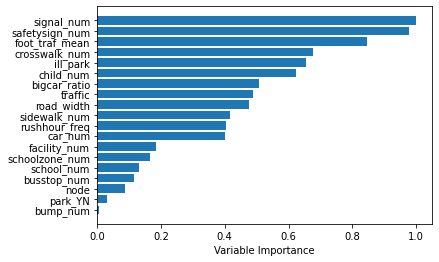

In [482]:
featureImportance = regressor.feature_importances_
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, X_train_rf.columns[sorted_idx])
plt.xlabel('Variable Importance')
plt.show()

In [483]:
predictions_rf = pd.DataFrame(data = y_pred, columns = ['predictions_rf'])
final = pd.concat([final,predictions_rf],axis=1)
final

,gid,geometry,accident_cnt,predictions_gwr,predictions_rf
0,다사620045,"MULTIPOLYGON (((127.07214 37.13843, 127.07214 ...",2,0.570446,0.699109
1,다사630040,"MULTIPOLYGON (((127.08343 37.13397, 127.08342 ...",2,0.266914,0.135140
2,다사600051,"MULTIPOLYGON (((127.04959 37.14376, 127.04959 ...",1,0.228247,0.170283
3,다사611072,"MULTIPOLYGON (((127.06187 37.16273, 127.06186 ...",1,0.228535,0.146103
4,다사625060,"MULTIPOLYGON (((127.07770 37.15197, 127.07769 ...",1,0.313850,0.269886
5,다사617041,"MULTIPOLYGON (((127.06879 37.13482, 127.06878 ...",2,0.475013,0.681185
6,다사611073,"MULTIPOLYGON (((127.06186 37.16363, 127.06186 ...",1,0.171136,0.219847
7,다사605070,"MULTIPOLYGON (((127.05512 37.16091, 127.05512 ...",2,0.084384,0.200171
8,다사612073,"MULTIPOLYGON (((127.06299 37.16364, 127.06299 ...",1,0.587399,0.547500
9,다사607068,"MULTIPOLYGON (((127.05739 37.15911, 127.05738 ...",3,0.337833,0.657839


# LightGBM

### 1. Train, Test data

In [484]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(165, 24) (165, 1) (42, 23) (42, 1)


In [485]:
X_train_lgb = X_train.drop(['gid','lat','lon','for_split','geometry'],axis=1)
y_train_lgb = y_train
X_test_lgb = X_test.drop(['gid','lat','lon','geometry'],axis=1)
y_test_lgb = y_test
print(X_train_lgb.shape, y_train_lgb.shape, X_test_lgb.shape, y_test_lgb.shape)

(165, 19) (165, 1) (42, 19) (42, 1)


In [486]:
feature_names = X_test_lgb.columns
feature_names

Index(['schoolzone_num', 'safetysign_num', 'bump_num', 'child_num',
       'school_num', 'facility_num', 'signal_num', 'busstop_num',
       'crosswalk_num', 'sidewalk_num', 'ill_park', 'car_num', 'node',
       'park_YN', 'foot_traf_mean', 'traffic', 'bigcar_ratio', 'rushhour_freq',
       'road_width'],
      dtype='object')

### 2. Scaling

모델링을 하기 전 Light GBM 역시 정규화를 시행해주었다

In [487]:
sc = StandardScaler()
X_train_lgb = sc.fit_transform(X_train_lgb)
X_test_lgb = sc.transform(X_test_lgb)
X_train_lgb = pd.DataFrame(X_train_lgb, columns = feature_names)
X_test_lgb = pd.DataFrame(X_test_lgb, columns = feature_names)
X_train_lgb.columns

Index(['schoolzone_num', 'safetysign_num', 'bump_num', 'child_num',
       'school_num', 'facility_num', 'signal_num', 'busstop_num',
       'crosswalk_num', 'sidewalk_num', 'ill_park', 'car_num', 'node',
       'park_YN', 'foot_traf_mean', 'traffic', 'bigcar_ratio', 'rushhour_freq',
       'road_width'],
      dtype='object')

### 3. Modeling

In [488]:
train_ds = lgb.Dataset(X_train_lgb,label = y_train_lgb)
test_ds = lgb.Dataset(X_train_lgb,label=y_train_lgb)
params = {'learning rate':0.1,
          'boosting':'gbdt',
          'objective':'regression',
          'metric':'mse',
          'is_training_metric':True,
          'bagging_fraction': 0.7,
          'feature_fraction': 0.9,
          'max_depth': 20,
          'min_child_weight': 10,
          'min_split_gain': 0.001,
          'num_leaves': 144,
          'bagging_freq':5,
          'seed':20210122}
model = lgb.train(params,train_ds,1000,test_ds,verbose_eval = 100,early_stopping_rounds=100)

y_pred = model.predict(X_test_lgb)
mse = mean_squared_error(y_test_lgb, y_pred)
rmse = np.sqrt(mse)
msle = mean_squared_log_error(y_test_lgb, y_pred + 1)
rmsle = np.sqrt(msle)

[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 165, number of used features: 17
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Info] Start training from score 0.339394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

Light GBM의 평가 측도는 아래와 같고, 데이터의 개수가 적어서 Random Forest 보다 성능이 안 좋은 것을 확인할 수 있다.

In [489]:
print(y_pred)
print('Mean Squared Error :', mse)
print('Root Mean Squared Error :', rmse)
print('Mean Squared Log Error :', msle)
print('Root Mean Squared Log Error :', rmsle)

[-0.36092247 -0.21457794 -0.23425685  0.17172183  0.90168013  0.64765147
 -0.59994658 -0.23279112 -0.45769651  1.01273126  0.33904205 -0.01166433
  1.06673234 -0.24889055  0.74041279  0.25835993 -0.03143432  0.38853405
  0.08111543  0.14106066  0.21096009  0.81920967  0.16710033  0.12576732
  0.04607788 -0.10444163  0.61700868  1.03098383  0.6856675   0.15863634
  0.64092358  0.36938395 -0.12350307 -0.65724875  0.99443254  0.44340517
 -0.24359381 -0.00225713 -0.32319008  0.19068223 -0.20595806  0.41860488]
Mean Squared Error : 0.8467374280403891
Root Mean Squared Error : 0.9201833665310349
Mean Squared Log Error : 0.5388191729266819
Root Mean Squared Log Error : 0.7340430320673863


실제 관측된 값이랑 예측된 값을 비교하였다

In [490]:
final_result = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(y_pred)], axis = 1)
final_result.columns = ['Label','Prediction']
print(final_result)

    Label  Prediction
0       2   -0.360922
1       2   -0.214578
2       1   -0.234257
3       1    0.171722
4       1    0.901680
5       2    0.647651
6       1   -0.599947
7       2   -0.232791
8       1   -0.457697
9       3    1.012731
10      0    0.339042
11      0   -0.011664
12      0    1.066732
13      0   -0.248891
14      0    0.740413
15      0    0.258360
16      0   -0.031434
17      0    0.388534
18      0    0.081115
19      0    0.141061
20      0    0.210960
21      0    0.819210
22      0    0.167100
23      0    0.125767
24      0    0.046078
25      0   -0.104442
26      0    0.617009
27      0    1.030984
28      0    0.685667
29      0    0.158636
30      0    0.640924
31      0    0.369384
32      0   -0.123503
33      0   -0.657249
34      0    0.994433
35      0    0.443405
36      0   -0.243594
37      0   -0.002257
38      0   -0.323190
39      0    0.190682
40      0   -0.205958
41      0    0.418605


<AxesSubplot:xlabel='Label', ylabel='Prediction'>

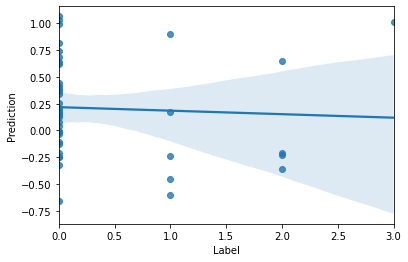

In [491]:
sns.regplot(x = 'Label', y = 'Prediction', data = final_result)

In [492]:
print('Feature names:', model.feature_name())

Feature names: ['schoolzone_num', 'safetysign_num', 'bump_num', 'child_num', 'school_num', 'facility_num', 'signal_num', 'busstop_num', 'crosswalk_num', 'sidewalk_num', 'ill_park', 'car_num', 'node', 'park_YN', 'foot_traf_mean', 'traffic', 'bigcar_ratio', 'rushhour_freq', 'road_width']


LightGBM을 통해 구한 Feature Importance 중 가장 영향력이 높은 변수 10개를 아래와 같이 그려보았다

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

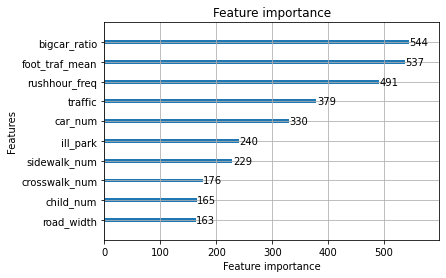

In [493]:
lgb.plot_importance(model, max_num_features=10)

In [494]:
predictions_lgbm = pd.DataFrame(data = y_pred, columns = ['predictions_lgbm'])
final = pd.concat([final,predictions_lgbm],axis=1)

In [495]:
final

,gid,geometry,accident_cnt,predictions_gwr,predictions_rf,predictions_lgbm
0,다사620045,"MULTIPOLYGON (((127.07214 37.13843, 127.07214 ...",2,0.570446,0.699109,-0.360922
1,다사630040,"MULTIPOLYGON (((127.08343 37.13397, 127.08342 ...",2,0.266914,0.135140,-0.214578
2,다사600051,"MULTIPOLYGON (((127.04959 37.14376, 127.04959 ...",1,0.228247,0.170283,-0.234257
3,다사611072,"MULTIPOLYGON (((127.06187 37.16273, 127.06186 ...",1,0.228535,0.146103,0.171722
4,다사625060,"MULTIPOLYGON (((127.07770 37.15197, 127.07769 ...",1,0.313850,0.269886,0.901680
5,다사617041,"MULTIPOLYGON (((127.06879 37.13482, 127.06878 ...",2,0.475013,0.681185,0.647651
6,다사611073,"MULTIPOLYGON (((127.06186 37.16363, 127.06186 ...",1,0.171136,0.219847,-0.599947
7,다사605070,"MULTIPOLYGON (((127.05512 37.16091, 127.05512 ...",2,0.084384,0.200171,-0.232791
8,다사612073,"MULTIPOLYGON (((127.06299 37.16364, 127.06299 ...",1,0.587399,0.547500,-0.457697
9,다사607068,"MULTIPOLYGON (((127.05739 37.15911, 127.05738 ...",3,0.337833,0.657839,1.012731


# Score for child

어린이 보호구역 내에서 가장 위험한 곳 20곳을 파악하기 위해 위험도 지수를 계산하였다. 이번 프로젝트에서 GWR, Random Forest, LightGBM 총 3개의 모델을 사용하였는데, 지수를 만드는데에는 GWR, Random Forest를 사용하였다.

In [12]:
dataset_num = dataset_child.drop(columns=["accident_cnt","gid","geometry","lat","lon"])
dataset_num

,schoolzone_num,safetysign_num,bump_num,child_num,school_num,facility_num,signal_num,busstop_num,crosswalk_num,sidewalk_num,ill_park,car_num,node,park_YN,foot_traf_mean,traffic,bigcar_ratio,rushhour_freq,road_width
0,1,0,0,0.0,0,0,0,0,0,0,0,14,1,0,10.848201,1542.707500,0.362590,81.262500,0.375000
1,1,0,0,6.0,0,0,0,0,0,0,0,36,0,0,16.517292,14931.657500,0.190651,23.547500,0.750000
2,1,1,0,0.0,0,0,0,0,0,1,0,7,0,0,31.879167,12951.074000,0.189168,22.230000,0.650000
3,1,0,0,0.0,1,0,1,0,3,0,0,0,0,0,11.574640,2316.091667,0.276260,55.203333,0.666667
4,1,0,0,0.0,0,0,4,2,3,0,10,0,0,0,7.814555,2324.453333,0.274590,38.578333,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,1,0,0,0.0,0,0,0,0,1,3,3,0,0,0,74.561528,2062.535000,0.240368,38.630000,0.750000
203,2,1,0,0.0,0,9,6,1,3,4,4,3,2,0,558.219290,7243.236000,0.188602,84.665000,0.650000
204,1,0,0,0.0,2,0,0,1,0,1,1,0,0,0,125.854896,12874.070000,0.174209,99.575000,0.750000
205,1,0,0,106.0,0,0,4,0,6,0,13,0,0,0,27.253655,4843.490000,0.222945,54.360000,0.750000


지수를 구하기 전, 어린이 보호구역 내의 데이터를 min-max scaler를 통해 가다듬었다. min-max scale을 통해 해당 변수 중 최댓값은 1을 갖게 되고, 최솟값은 0을 갖게 된다.

In [13]:
dataset_num_scaled = minmax_scale(dataset_num,axis=0)
dataset_num_scaled = pd.DataFrame(dataset_num_scaled)
dataset_num_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.006931,0.2,0.0,0.012267,0.074853,1.000000,0.815807,0.166667
1,0.000000,0.00,0.0,0.037037,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.017822,0.0,0.0,0.018908,0.769431,0.517815,0.236397,0.666667
2,0.000000,0.25,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.066667,0.000000,0.003465,0.0,0.0,0.036906,0.666685,0.513655,0.223170,0.533333
3,0.000000,0.00,0.0,0.000000,0.333333,0.000000,0.1,0.0,0.230769,0.000000,0.000000,0.000000,0.0,0.0,0.013118,0.114974,0.757896,0.554195,0.555556
4,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.4,1.0,0.230769,0.000000,0.007570,0.000000,0.0,0.0,0.008713,0.115408,0.753214,0.387294,0.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.076923,0.200000,0.002271,0.000000,0.0,0.0,0.086910,0.101820,0.657240,0.387812,0.666667
203,0.333333,0.25,0.0,0.000000,0.000000,0.214286,0.6,0.5,0.230769,0.266667,0.003028,0.001485,0.4,0.0,0.653541,0.370579,0.512069,0.849965,0.533333
204,0.000000,0.00,0.0,0.000000,0.666667,0.000000,0.0,0.5,0.000000,0.066667,0.000757,0.000000,0.0,0.0,0.147003,0.662690,0.471705,0.999649,0.666667
205,0.000000,0.00,0.0,0.654321,0.000000,0.000000,0.4,0.0,0.461538,0.000000,0.009841,0.000000,0.0,0.0,0.031487,0.246088,0.608381,0.545728,0.666667


In [14]:
dataset_num_scaled.columns = dataset_num.columns
dataset_num_scaled.columns

Index(['schoolzone_num', 'safetysign_num', 'bump_num', 'child_num',
       'school_num', 'facility_num', 'signal_num', 'busstop_num',
       'crosswalk_num', 'sidewalk_num', 'ill_park', 'car_num', 'node',
       'park_YN', 'foot_traf_mean', 'traffic', 'bigcar_ratio', 'rushhour_freq',
       'road_width'],
      dtype='object')

아래 w의 수치는 Random Forest에서 구한 변수들의 중요도를 반영해서 선정하였다. 영향이 거의 변수들은 제외하였고, 위험도 지수를 만드는데 총 12개의 변수를 사용하였다.

In [15]:
w = [0, 100, 0, 60, 0, 0, 100, 0, 60, -40, 60, 40, 0, 0, 80, 50, -50, 40, 50]

In [16]:
risk = []
for i in range(len(dataset_num_scaled)):
    risk.append(sum(np.array(dataset_num_scaled.iloc[i,:]*w)))

어린이 보호구역 내의 위험도 지수는 아래와 같다

In [17]:
risk

[-4.033185065243069,
 59.81776468009622,
 68.66936361772412,
 42.695026369793496,
 66.3765510516817,
 25.467741503925605,
 70.0347383431572,
 23.740563061087798,
 33.51747767698739,
 35.63985491178734,
 84.04757094622886,
 49.6773226879871,
 41.87927292456175,
 22.739251903083716,
 68.95155673934124,
 55.31665417814888,
 99.44659733807075,
 72.29805144250304,
 41.17260438021532,
 51.46887944950465,
 59.89398807511092,
 54.79152955527691,
 211.3131755237779,
 21.487015534898553,
 27.610568282336565,
 25.245813637832498,
 38.35076921207609,
 24.144289792981393,
 91.98028928227734,
 37.877197104257455,
 46.186930370392375,
 11.938569223445633,
 41.15059196263516,
 17.772331889469157,
 38.19124018247304,
 27.31081081131307,
 30.171444679778773,
 8.05428731201005,
 42.98783148137779,
 66.86369046194014,
 51.50158756369316,
 35.37306403792942,
 43.64529051019406,
 57.44028572635178,
 7.221045361415671,
 73.17257840935181,
 159.90290095616612,
 51.75120928858423,
 55.67530350555986,
 25.51753

해당 위험도 지수값을 실제 사고 건수와 비교해보았다

In [18]:
score = pd.concat([dataset_child,pd.DataFrame({"risk":risk})],axis=1)
score = score[["gid","geometry","accident_cnt","risk"]]

In [19]:
score

,gid,geometry,accident_cnt,risk
0,다사571088,"MULTIPOLYGON (((127.01673 37.17698, 127.01672 ...",0,-4.033185
1,다사578109,"MULTIPOLYGON (((127.02449 37.19594, 127.02449 ...",0,59.817765
2,다사579109,"MULTIPOLYGON (((127.02562 37.19595, 127.02561 ...",0,68.669364
3,다사580079,"MULTIPOLYGON (((127.02692 37.16891, 127.02691 ...",0,42.695026
4,다사580080,"MULTIPOLYGON (((127.02691 37.16981, 127.02690 ...",0,66.376551
...,...,...,...,...
202,다사631037,"MULTIPOLYGON (((127.08457 37.13127, 127.08456 ...",0,24.779284
203,다사631038,"MULTIPOLYGON (((127.08456 37.13217, 127.08456 ...",2,194.294644
204,다사631039,"MULTIPOLYGON (((127.08456 37.13307, 127.08455 ...",0,92.007537
205,다사637059,"MULTIPOLYGON (((127.09122 37.15112, 127.09121 ...",0,147.108775


In [20]:
score = score.sort_values(by='risk',ascending=False)
score.iloc[0:29]

,gid,geometry,accident_cnt,risk
172,다사624061,"MULTIPOLYGON (((127.07657 37.15287, 127.07656 ...",6,250.855312
180,다사625067,"MULTIPOLYGON (((127.07766 37.15828, 127.07766 ...",4,219.292683
107,다사617042,"MULTIPOLYGON (((127.06878 37.13572, 127.06878 ...",0,212.911107
22,다사595085,"MULTIPOLYGON (((127.04378 37.17438, 127.04377 ...",3,211.313176
203,다사631038,"MULTIPOLYGON (((127.08456 37.13217, 127.08456 ...",2,194.294644
59,다사604086,"MULTIPOLYGON (((127.05391 37.17532, 127.05391 ...",1,191.308902
63,다사605069,"MULTIPOLYGON (((127.05513 37.16000, 127.05512 ...",0,168.722505
52,다사603046,"MULTIPOLYGON (((127.05300 37.13926, 127.05299 ...",0,167.858153
178,다사625061,"MULTIPOLYGON (((127.07769 37.15288, 127.07769 ...",0,164.478744
191,다사627063,"MULTIPOLYGON (((127.07993 37.15469, 127.07993 ...",1,161.666804


### 6. Score Graph

In [21]:
score

,gid,geometry,accident_cnt,risk
172,다사624061,"MULTIPOLYGON (((127.07657 37.15287, 127.07656 ...",6,250.855312
180,다사625067,"MULTIPOLYGON (((127.07766 37.15828, 127.07766 ...",4,219.292683
107,다사617042,"MULTIPOLYGON (((127.06878 37.13572, 127.06878 ...",0,212.911107
22,다사595085,"MULTIPOLYGON (((127.04378 37.17438, 127.04377 ...",3,211.313176
203,다사631038,"MULTIPOLYGON (((127.08456 37.13217, 127.08456 ...",2,194.294644
...,...,...,...,...
44,다사602045,"MULTIPOLYGON (((127.05188 37.13836, 127.05187 ...",0,7.221045
188,다사627048,"MULTIPOLYGON (((127.08001 37.14117, 127.08000 ...",1,5.487307
82,다사610069,"MULTIPOLYGON (((127.06076 37.16003, 127.06075 ...",0,2.684554
0,다사571088,"MULTIPOLYGON (((127.01673 37.17698, 127.01672 ...",0,-4.033185


In [22]:
score_merge2 = pd.merge(dataset_child,score.iloc[:, [0,3]], on='gid')

In [59]:
score_column_list2 = ['gid','safetysign_num', 'child_num', 
                      'signal_num', 'crosswalk_num', 
                      'sidewalk_num', 'ill_park', 
                      'car_num',  'foot_traf_mean', 
                      'traffic', 'bigcar_ratio', 
                      'rushhour_freq','road_width']

In [23]:
bins = [0, 50, 100, math.inf]
label = ['안전', '주의', '위험']
test = pd.cut(score_merge2['risk'], bins, right = False, labels = label)
score_merge2['위험도'] = test

In [24]:
안전지역2 = score_merge2[score_merge2['위험도']=='안전']
주의지역2 = score_merge2[score_merge2['위험도']=='주의']
위험지역2 = score_merge2[score_merge2['위험도']=='위험']

In [25]:
#어린이 보호구역 지역 데이터
GetCompasData('SBJ_2012_001', '9', '9.오산시_어린이보호구역.csv')
child_zone = pd.read_csv('9.오산시_어린이보호구역.csv')

In [28]:
geom9 = gpd.points_from_xy(child_zone['보호구역_경도'], child_zone['보호구역_위도'])
gpd9 = gpd.GeoDataFrame(geometry = geom9, crs=from_epsg(4326))
crs9 = gpd9.to_crs(epsg='4326')

In [65]:
child_zone['geo'] = gpd9

In [68]:
안전_json = 안전지역2.to_json()
주의_json = 주의지역2.to_json()
위험_json = 위험지역2.to_json()
child_json =  crs9.to_json()

#map 기본 정보
m = folium.Map(
    location = [37.16323633764299, 127.05128286756862],
    zoom_start=14
)


#map 타일추가
folium.TileLayer('http://api.vworld.kr/req/wmts/1.0.0/A0D28BDF-548E-38C9-BFE4-ACBC9CF80602/Satellite/{z}/{y}/{x}.jpeg',
                 attr='오산시',
                 name='실사지도', overlay= True).add_to(m)

folium.TileLayer(tiles = 'http://api.vworld.kr/req/wmts/1.0.0/A0D28BDF-548E-38C9-BFE4-ACBC9CF80602/Hybrid/{z}/{y}/{x}.png', 
                 attr = '고양시', 
                 name = '건물 정보',
                 overlay = True).add_to(m)


#안전, 주의, 위험에 따라 그룹
fg = folium.FeatureGroup(name='전체')
g1 = plugins.FeatureGroupSubGroup(fg, '안전')
g2 = plugins.FeatureGroupSubGroup(fg, '주의')
g3 = plugins.FeatureGroupSubGroup(fg, '위험')

m.add_child(fg)
m.add_child(g1)
m.add_child(g2)
m.add_child(g3)


#안전, 주의, 위험 각 지역 위치 정보 mapping
choro1 = folium.Choropleth(
    geo_data=안전_json,
    fill_color = 'green'
)

choro1.add_to(g1)

choro2 = folium.Choropleth(
    geo_data=주의_json,
    fill_color = 'orange'
)

choro2.add_to(g2)

choro3 = folium.Choropleth(
    geo_data=위험_json,
    fill_color = 'red'
)

choro3.add_to(g3)


child_area = folium.Choropleth(
    geo_data = child_json,
)

child_area.add_to(fg)

#검색창
plugins.Search(layer = fg,
              geom_type = 'Polygon',
              search_label = 'gid',
              search_zoom = 17
              ).add_to(m)



#Popup창 뜨게 하기
choro1.geojson.add_child(
    folium.features.GeoJsonTooltip(score_column_list2, labels = True)
)
choro2.geojson.add_child(
    folium.features.GeoJsonTooltip(score_column_list2, labels = True)
)
choro3.geojson.add_child(
    folium.features.GeoJsonTooltip(score_column_list2, labels = True)
)

#마우스 올렸을 때 오른쪽 위에 좌표 생성
formatter = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"

plugins.MousePosition(
    position='topright',
    separator=' | ',
    empty_string='NaN',
    lng_first=True,
    num_digits=20,
    prefix='Coordinates:',
    lat_formatter=formatter,
    lng_formatter=formatter,
).add_to(m)



#오른쪽 상단에 그룹 control창 생성
folium.LayerControl(collapsed=False).add_to(m)



m

In [51]:
score.iloc[0:29]

,gid,geometry,accident_cnt,risk
172,다사624061,"MULTIPOLYGON (((127.07657 37.15287, 127.07656 ...",6,250.855312
180,다사625067,"MULTIPOLYGON (((127.07766 37.15828, 127.07766 ...",4,219.292683
107,다사617042,"MULTIPOLYGON (((127.06878 37.13572, 127.06878 ...",0,212.911107
22,다사595085,"MULTIPOLYGON (((127.04378 37.17438, 127.04377 ...",3,211.313176
203,다사631038,"MULTIPOLYGON (((127.08456 37.13217, 127.08456 ...",2,194.294644
59,다사604086,"MULTIPOLYGON (((127.05391 37.17532, 127.05391 ...",1,191.308902
63,다사605069,"MULTIPOLYGON (((127.05513 37.16000, 127.05512 ...",0,168.722505
52,다사603046,"MULTIPOLYGON (((127.05300 37.13926, 127.05299 ...",0,167.858153
178,다사625061,"MULTIPOLYGON (((127.07769 37.15288, 127.07769 ...",0,164.478744
191,다사627063,"MULTIPOLYGON (((127.07993 37.15469, 127.07993 ...",1,161.666804


In [80]:
score_merge2[score_merge2['gid']=='다사605069']

,gid,accident_cnt,schoolzone_num,safetysign_num,bump_num,child_num,school_num,facility_num,signal_num,busstop_num,...,foot_traf_mean,traffic,bigcar_ratio,rushhour_freq,road_width,geometry,lat,lon,risk,위험도
63,다사605069,0,1,0,0,36.0,0,8,7,1,...,164.730729,4083.7,0.098268,54.45,0.75,"MULTIPOLYGON (((127.05513 37.16000, 127.05512 ...",37.160457,127.055688,168.722505,위험


In [45]:
child_위험상위30 = score.iloc[0:29]
child_30 = pd.merge(dataset_child,child_위험상위30.iloc[:,[0,3]], on='gid')

In [50]:
gdf = child_30.to_crs(epsg='4326')
converted_json = gdf.to_json()

m = folium.Map(
    location = [37.16908, 127.06921],
    tiles = 'http://api.vworld.kr/req/wmts/1.0.0/A0D28BDF-548E-38C9-BFE4-ACBC9CF80602/Satellite/{z}/{y}/{x}.jpeg', 
    attr = '오산시',
    zoom_start=15
)

folium.TileLayer('http://api.vworld.kr/req/wmts/1.0.0/A0D28BDF-548E-38C9-BFE4-ACBC9CF80602/Hybrid/{z}/{y}/{x}.png',
                 attr='오산시',
                 name = '건물정보',
                 overlay=True
                ).add_to(m)

choropleth = folium.Choropleth(
    geo_data=converted_json,
    fill_color = 'red'
).add_to(m)


#검색창 생성
plugins.Search(layer = choropleth,
              geom_type = 'Polygon',
              search_label = 'gid',
              search_zoom = 17
              ).add_to(m)


#popup 창 생성
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(score_column_list2, labels = True)
)


#마우스 올렸을 때 오른쪽 위에 좌표 생성
formatter = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"

plugins.MousePosition(
    position='topright',
    separator=' | ',
    empty_string='NaN',
    lng_first=True,
    num_digits=20,
    prefix='Coordinates:',
    lat_formatter=formatter,
    lng_formatter=formatter,
).add_to(m)

m